# Purpose
This notebook's purpose is to produce the model checking plots of the MIXLB model that will be needed in the 3rd version of the paper for ArXiv.

# Notebook parameters

In [1]:
# Declare paths to where data is or should be stored
DATA_PATH =\
    "../../data/processed/model_ready_car_data.csv"

PARAM_PATH =\
    "../../models/estimated_mixlb_parameters.csv"

HESSIAN_PATH =\
    "../../models/estimated_mixlb_hessian.csv"

POSTERIOR_PROB_PATH =\
    "../../models/posterior_probs_mixlb.csv"

FIGURE_DIR =\
    "../../reports/figures/mixlb"

# Note needed column names
ALT_ID_COLUMN = 'alt_id'
OBS_ID_COLUMN = 'obs_id'
CHOICE_COLUMN = 'choice'
BODY_COLUMN = 'body_type'
FUEL_COLUMN = 'fuel_type'

# Note the number of samples being drawn for the model checking
NUM_SAMPLES = 200
# Note the number of draws being used for Monte Carlo integration
# in the probability function
NUM_MIXING_DRAWS = 250
# Note the seed for generating the random variate draws for
# Monte Carlo integration in the probability function. Ensures
# we use the same random variate draws used to estimate the model
# and hessian.
MIXL_DRAW_SEED = 601

# Random seed for reproducibility of model checking
SEED = 1131

# Import modules

In [2]:
# Built-in modules
import sys
import time
import pathlib

# Third-party modules
import torch
import numpy as np
import pandas as pd
import pylogit as pl
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

import seaborn as sbn

# Local modules
sys.path.insert(0, '../../')
import src.viz as viz
import src.models.mixlb as mixlb
import src.models.torch_utils as utils
from src.models.model_inputs import InputMixlB

# Load needed data

In [3]:
# Get the dataframe of data for the model
car_df = pd.read_csv(DATA_PATH)

# Get the esimated parameters and hessian of the model
estimated_params =\
    np.loadtxt(PARAM_PATH, delimiter=',', skiprows=1)
estimated_hessian = np.loadtxt(HESSIAN_PATH, delimiter=',')

# Get the observation_ids
observation_ids = car_df[OBS_ID_COLUMN].values

# Get the choices from the dataset
choice_array = car_df[CHOICE_COLUMN].values

# Load pytorch model and needed objects

In [4]:
# Instantiate the model
mixl_model = mixlb.MIXLB()

# Create the various input objects needed for mixlb model.
mixlb_input = InputMixlB.from_df(car_df)

# Create target variables for the loss function
torch_choices =\
    torch.from_numpy(choice_array.astype(np.float32)).double()

# Create sampling distribution

In [8]:
# Extract the portion of the hessian pertaining to estimated
# parameters, excluding rows and columns for the fixed parameters
desired_rows =\
    np.concatenate((np.arange(0, 21), np.arange(23, 27)), axis=0)
hessian_core =\
    estimated_hessian[np.ix_(desired_rows, desired_rows)]

# Get the asymptotic covariance matrix.
# Note we don't multiply by -1 because this is the hessian
# of the log-loss as opposed to the log-likelihood. The
# -1 is already included in the log-loss definition.
asymptotic_cov = np.linalg.inv(hessian_core)

# Create the asymptotic sampling distribution,
# accounting for the parameters fixed to zero
asymptotic_sampling_dist =\
    multivariate_normal(mean=estimated_params[desired_rows],
                        cov=asymptotic_cov)

# Sample $\left( y, \theta \right)$ from posterior distribution

In [9]:
# Set a random seed for reproducibility
np.random.seed(SEED)

# Sample the estimated parameters
posterior_samples_estimated =\
    asymptotic_sampling_dist.rvs(size=(NUM_SAMPLES,))

# Get a complete array of posterior samples, including the
# parameters fixed to zero
posterior_samples =\
    np.concatenate((posterior_samples_estimated[:, np.arange(0, 21)],
                    np.zeros((NUM_SAMPLES, 2)),
                    posterior_samples_estimated[:, np.arange(21, 25)]),
                   axis=1)

In [10]:
# Initialize the tensor of posterior probabilities
posterior_probs_tensor =\
    torch.empty((mixlb_input.design.shape[0], NUM_SAMPLES),
                dtype=torch.double)

# Compute the probabilities for each posterior sample of parameters
with torch.no_grad():
    for idx in tqdm(range(NUM_SAMPLES), total=NUM_SAMPLES):
        # Set model parameters
        mixl_model.set_params_numpy(posterior_samples[idx, :])
        # Compute probabilities and assign them to the array
        posterior_probs_tensor[:, idx] =\
            mixl_model(design_2d=mixlb_input.design,
                       rows_to_obs=mixlb_input.obs_mapping,
                       rows_to_mixers=mixlb_input.mixing_mapping,
                       normal_rvs_list=mixlb_input.normal_rvs)

In [11]:
# Convert the tensor into a numpy array
posterior_probs_array = posterior_probs_tensor.numpy()

# Save the posterior probabilities
np.savetxt(POSTERIOR_PROB_PATH,
           posterior_probs_array,
           delimiter=",")

# Get the simulated choices based on the posterior probabilities
sim_choices =\
    viz.simulate_choice_vector(posterior_probs_array, observation_ids)

# Produce desired plots

In [12]:
# Create the directory for the model checking plots
pathlib.Path(FIGURE_DIR).mkdir(parents=True, exist_ok=True)

## 1. Predictive performance plots

### 1a. Overall Log-likelihood plot

In [13]:
# Create the path to where the plot should be saved
overall_log_likelihood_path =\
    pathlib.Path(FIGURE_DIR) / 'overall_log_likelihood.jpg'

# Compute the observed log-likelihood
with torch.no_grad():
    # Set the estimated parameters
    mixl_model.set_params_numpy(estimated_params)
    # Compute the estimated probabilities
    estimated_probs =\
        mixl_model(design_2d=mixlb_input.design,
                   rows_to_obs=mixlb_input.obs_mapping,
                   rows_to_mixers=mixlb_input.mixing_mapping,
                   normal_rvs_list=mixlb_input.normal_rvs)
    # Compute the observed log-likelihood
    obs_log_likelihood =\
        (-1 * utils.log_loss(estimated_probs, torch_choices)).item()

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


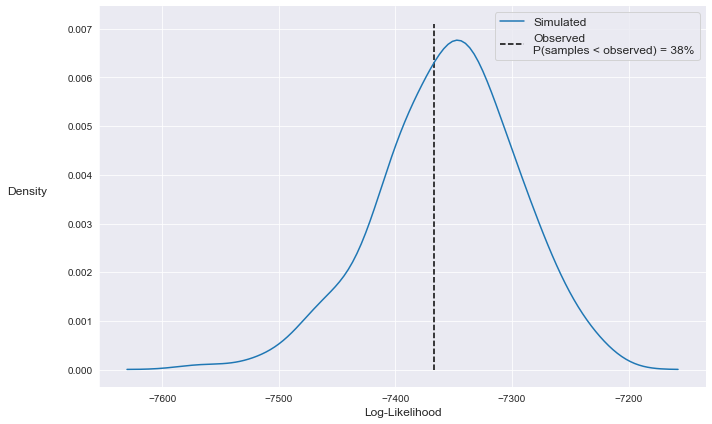

In [14]:
# Compute the simulated log-likelihood values
sim_log_likelihoods =\
    viz.compute_predictive_log_likelihoods(
        sim_choices, estimated_probs.numpy())

# Create the desired plot
viz.plot_continous_scalars(sim_log_likelihoods,
                           obs_log_likelihood,
                           output_file=overall_log_likelihood_path,
                          )


### 1b. Overall mean-square-error plot

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


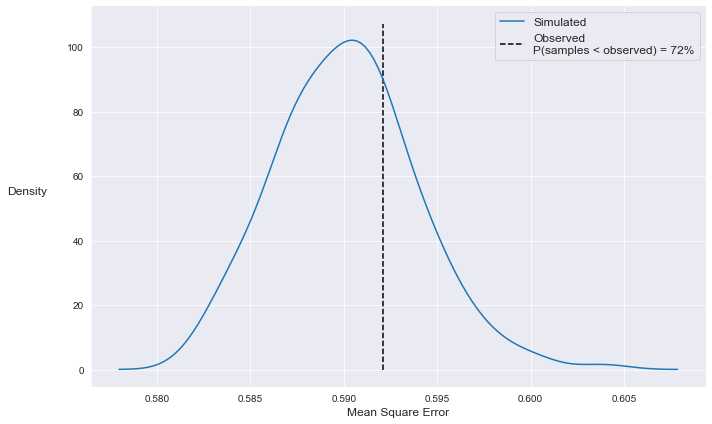

In [15]:
# Create the path to where the plot should be saved
overall_mse_path =\
    pathlib.Path(FIGURE_DIR) / 'overall_mean_square_error.jpg'

# Compute the observed mean-square-error values
obs_squared_errors = (choice_array - estimated_probs.numpy())**2
obs_mean_square_error =\
    obs_squared_errors[np.where(choice_array)].mean()

# Compute the simulated mean-square-errorvalues
sim_mean_square_error =\
    viz.compute_predictive_mse(
        sim_choices, estimated_probs.numpy())

# Create the desired plot
viz.plot_continous_scalars(sim_mean_square_error,
                           obs_mean_square_error,
                           x_label='Mean Square Error',
                           output_file=overall_mse_path,
                          )

### 1c. Log-likelihood plots by body and fuel type

In [16]:
# Get the available body and fuel types
body_types = car_df[BODY_COLUMN].unique()
fuel_types = car_df[FUEL_COLUMN].unique()

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using modul

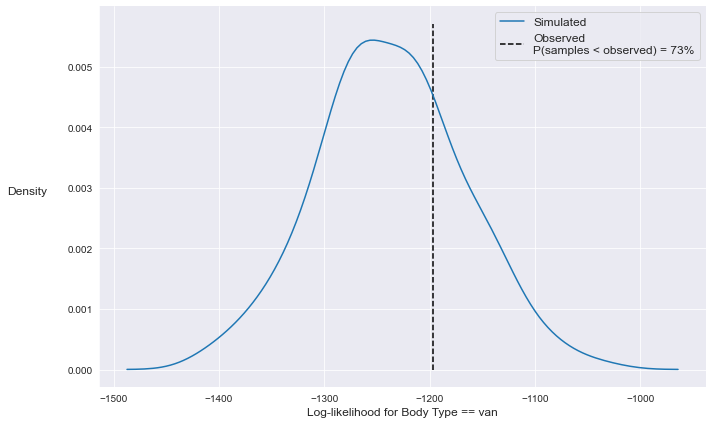

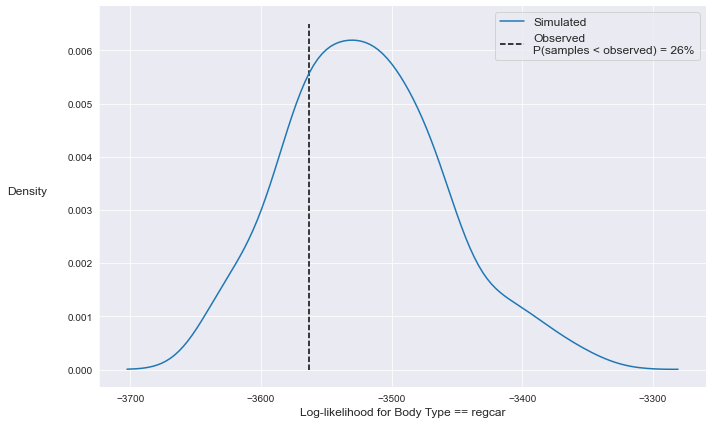

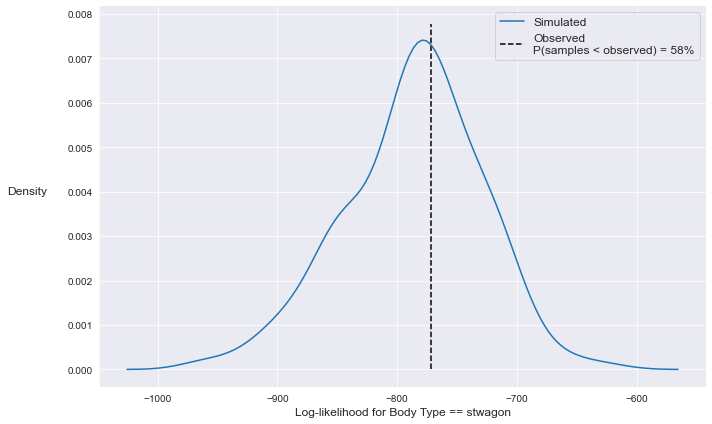

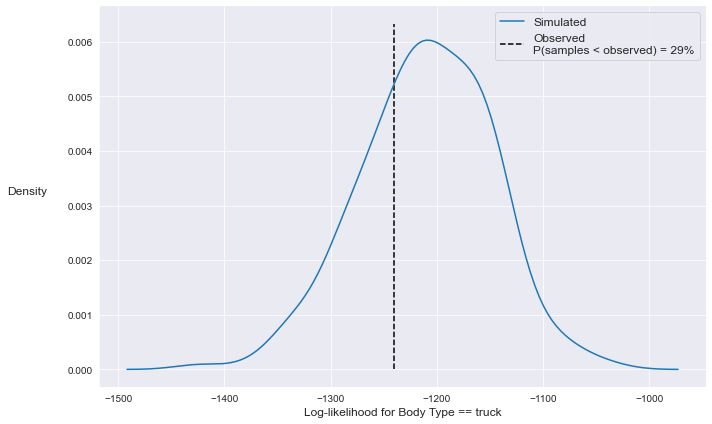

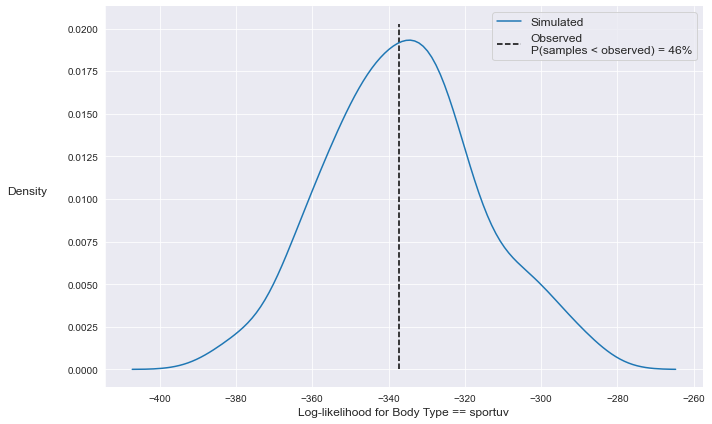

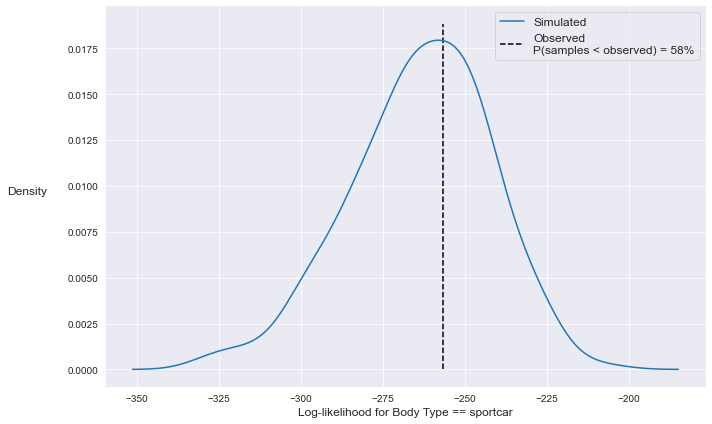

In [17]:
# Create the plot observed vs simulated log-likelihoods for each body type
for body in body_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[BODY_COLUMN] == body).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = choice_array[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]

    # Compute the observed log-likelihood for filtered obs
    current_log_likelihood =\
        np.dot(current_choices, np.log(current_probs))

    # Compute the simulated log-likelihoods for the filtered obs
    current_sim_log_likelihoods =\
        viz.compute_predictive_log_likelihoods(
            current_sim_choices, current_probs)

    # Create the label for the current plot
    current_label_base = 'Log-likelihood for Body Type == {}'
    current_label = current_label_base.format(body)

    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'log_likelihood_plot_body_is_{}.jpg'.format(body)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix

    # Create the current plot
    viz.plot_continous_scalars(current_sim_log_likelihoods,
                               current_log_likelihood,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


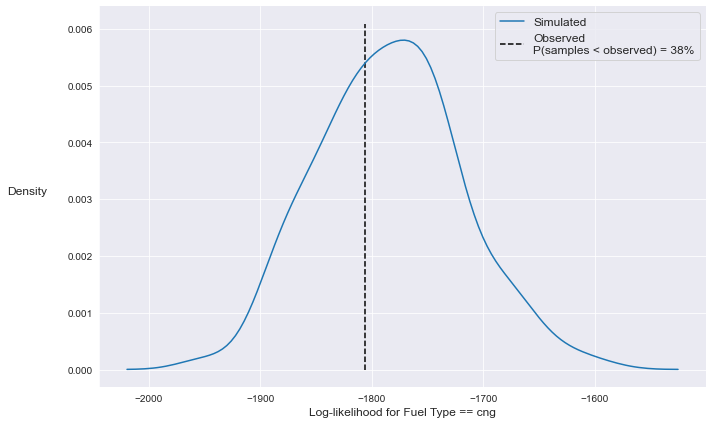

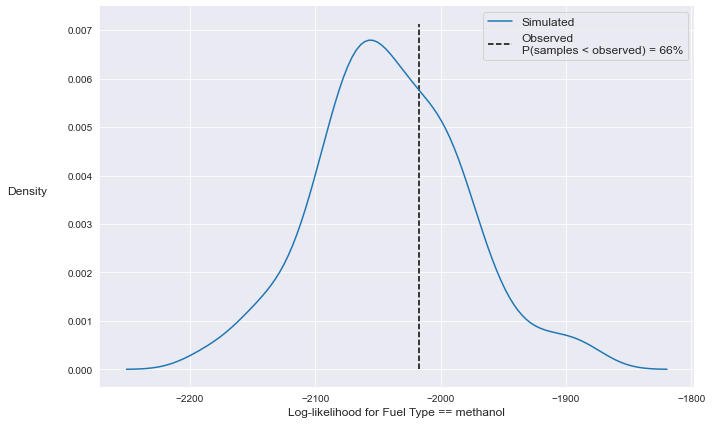

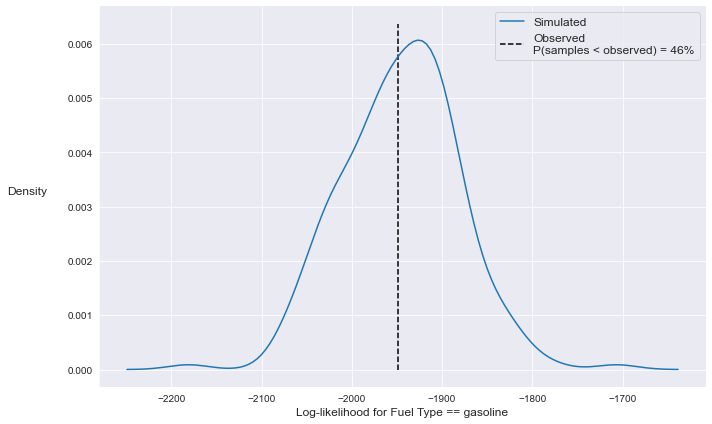

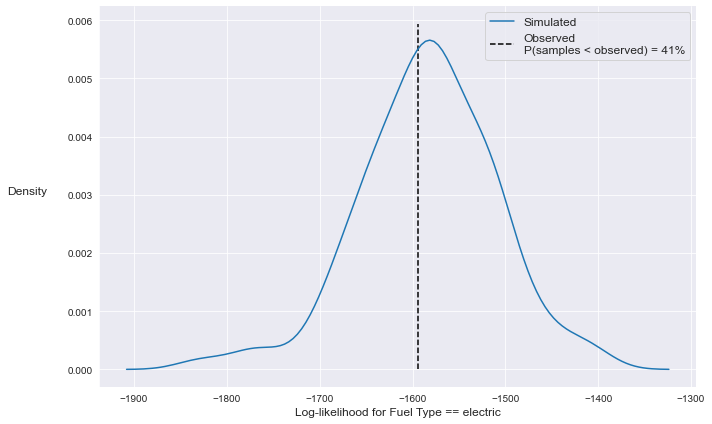

In [18]:
# Create the plot observed vs simulated log-likelihoods for each fuel type
for fuel in fuel_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[FUEL_COLUMN] == fuel).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = choice_array[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]

    # Compute the observed log-likelihood for filtered obs
    current_log_likelihood =\
        np.dot(current_choices, np.log(current_probs))

    # Compute the simulated log-likelihoods for the filtered obs
    current_sim_log_likelihoods =\
        viz.compute_predictive_log_likelihoods(
            current_sim_choices, current_probs)

    # Create the label for the current plot
    current_label_base = 'Log-likelihood for Fuel Type == {}'
    current_label = current_label_base.format(fuel)

    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'log_likelihood_plot_fuel_is_{}.jpg'.format(fuel)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix

    # Create the current plot
    viz.plot_continous_scalars(current_sim_log_likelihoods,
                               current_log_likelihood,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

### 1d. Mean-square-error plots by body and fuel type

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using modul

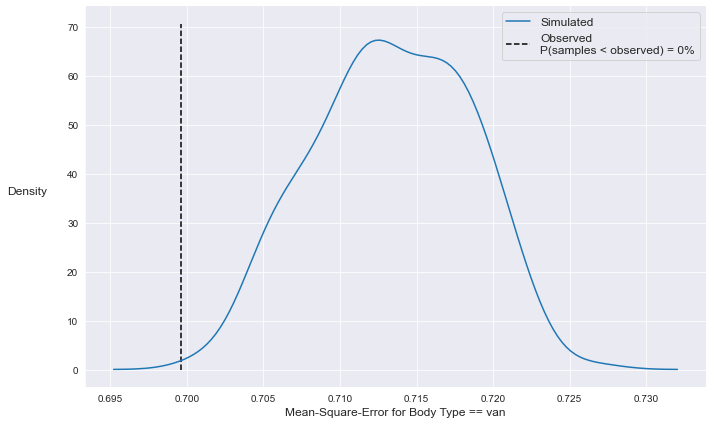

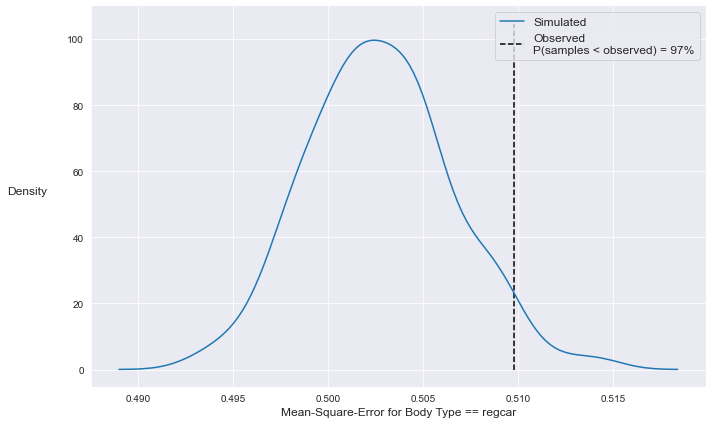

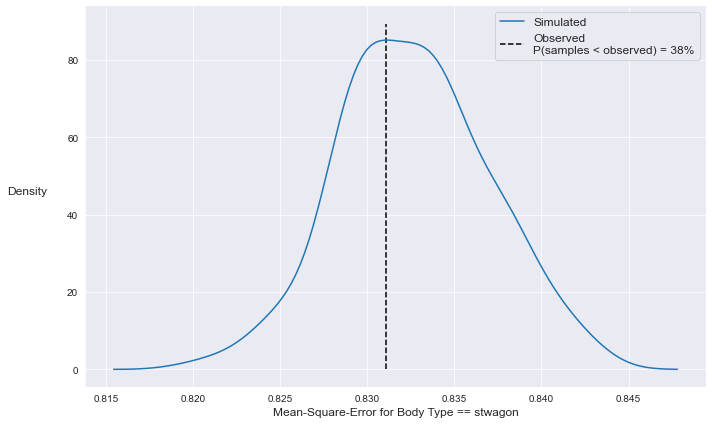

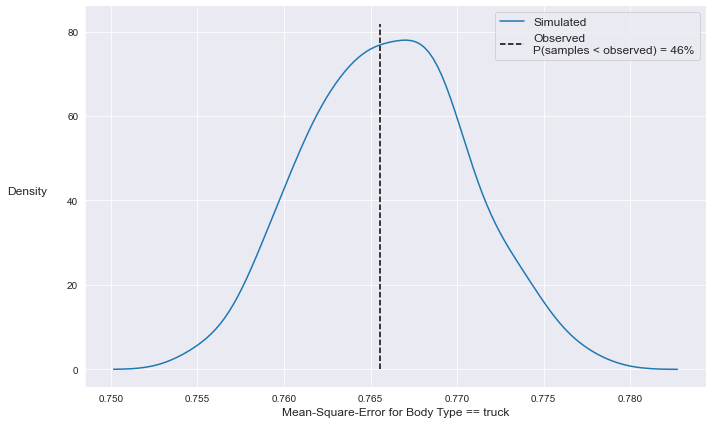

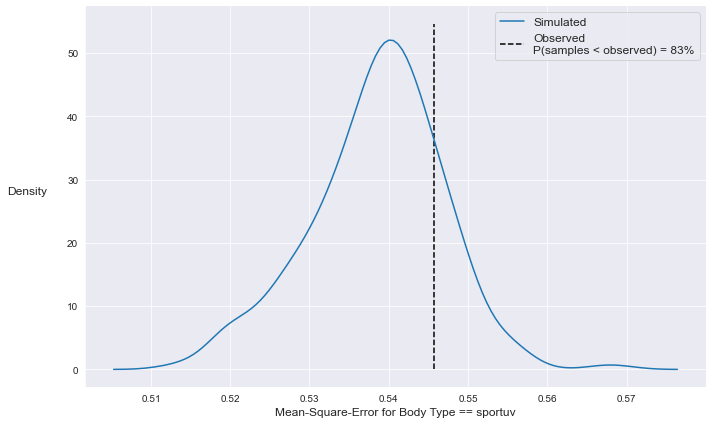

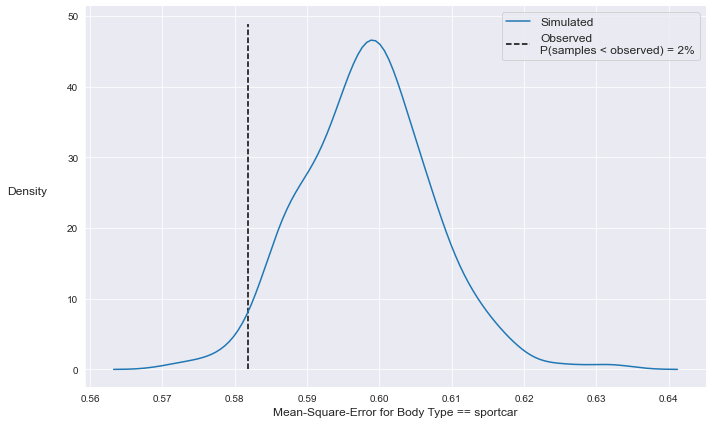

In [19]:
# Create the plot observed vs simulated mean-square-errors for each body type
for body in body_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[BODY_COLUMN] == body).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = choice_array[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]

    # Compute the observed mean-square-error for filtered obs
    current_square_error = (current_choices - current_probs)**2
    current_mean_square_error =\
        current_square_error[np.where(current_choices)].mean()

    # Compute the simulated mean-square-errors for the filtered obs
    current_sim_mean_square_errors =\
        viz.compute_predictive_mse(
            current_sim_choices, current_probs)

    # Create the label for the current plot
    current_label_base = 'Mean-Square-Error for Body Type == {}'
    current_label = current_label_base.format(body)

    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'mean_square_error_plot_body_is_{}.jpg'.format(body)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix

    # Create the current plot
    viz.plot_continous_scalars(current_sim_mean_square_errors,
                               current_mean_square_error,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


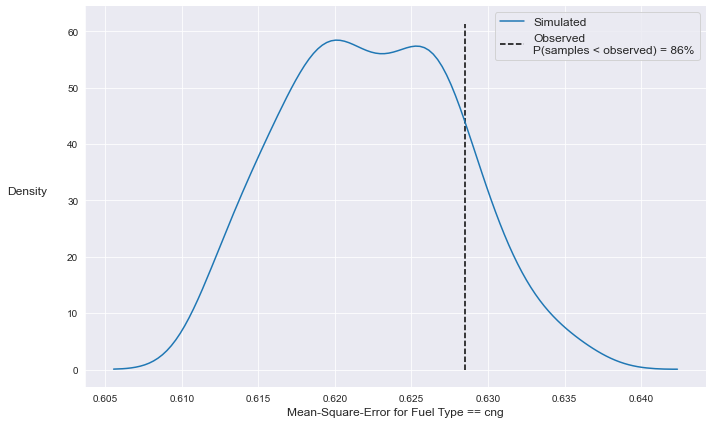

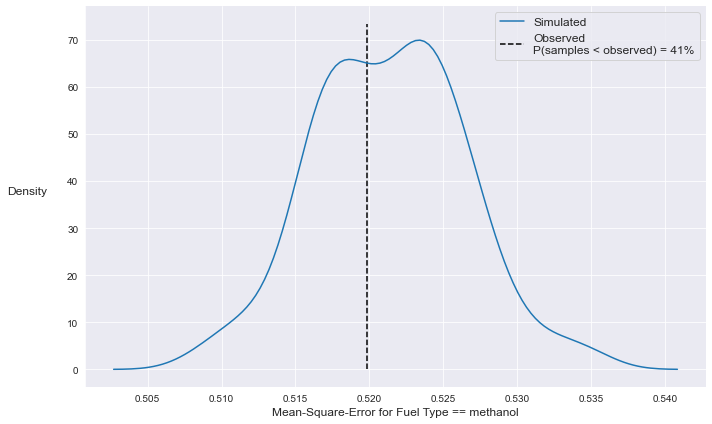

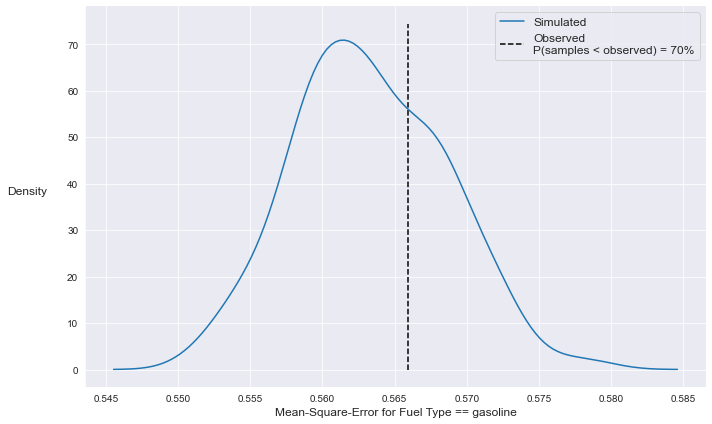

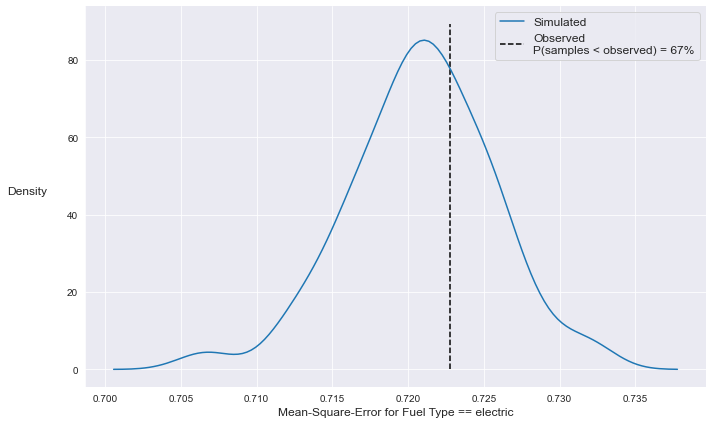

In [20]:
# Create the plot observed vs simulated mean-square-errors for each fuel type
for fuel in fuel_types:
    # Filter the observations being used for the plot
    filter_array = (car_df[FUEL_COLUMN] == fuel).values
    filter_idx = np.where(filter_array)

    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = choice_array[filter_idx]
    current_sim_choices = sim_choices[filter_idx[0], :]

    # Compute the observed mean-square-error for filtered obs
    current_square_error = (current_choices - current_probs)**2
    current_mean_square_error =\
        current_square_error[np.where(current_choices)].mean()

    # Compute the simulated mean-square-errors for the filtered obs
    current_sim_mean_square_errors =\
        viz.compute_predictive_mse(
            current_sim_choices, current_probs)

    # Create the label for the current plot
    current_label_base = 'Mean-Square-Error for Fuel Type == {}'
    current_label = current_label_base.format(fuel)

    # Create the path to where this plot should be stored
    plot_file_suffix =\
        'mean_square_error_plot_body_is_{}.jpg'.format(fuel)
    current_plot_path =\
        pathlib.Path(FIGURE_DIR) / plot_file_suffix

    # Create the current plot
    viz.plot_continous_scalars(current_sim_mean_square_errors,
                               current_mean_square_error,
                               x_label=current_label,
                               output_file=current_plot_path,
                              )

## 2. Market share plots

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


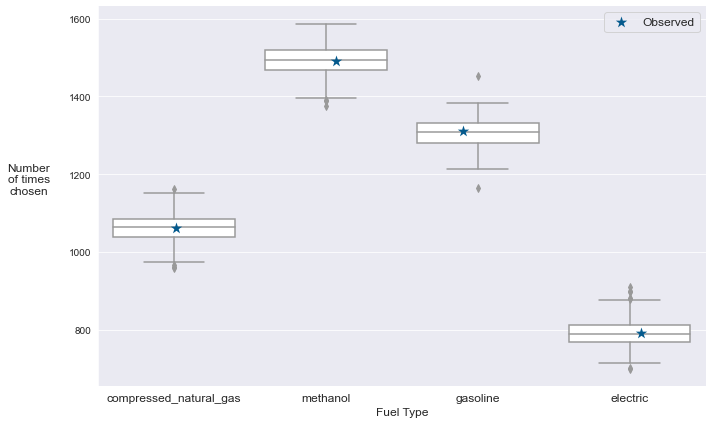

In [21]:
market_path = pathlib.Path(FIGURE_DIR) / 'market_share_plot_fuel_type.jpg'
market_dict = dict(cng='compressed_natural_gas')

viz.plot_simulated_market_shares(car_df.fuel_type.values,
                                 sim_choices,
                                 car_df.choice.values,
                                 x_label='Fuel Type',
                                 y_label='Number\nof times\nchosen',
                                 display_dict=market_dict,
                                 output_file=market_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


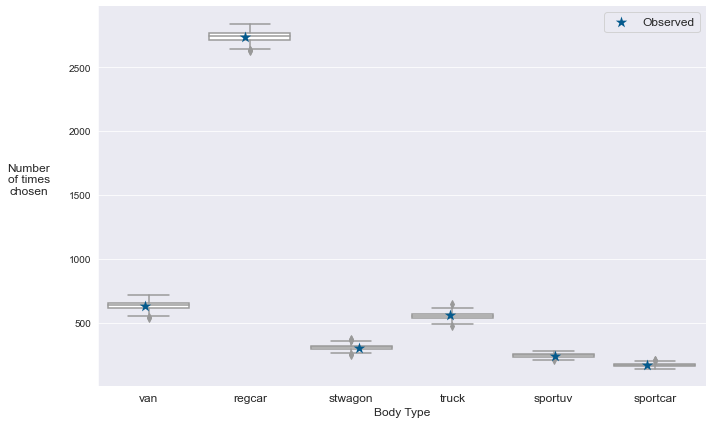

In [22]:
market_path_body = pathlib.Path(FIGURE_DIR) / 'market_share_plot_body_type.jpg'
viz.plot_simulated_market_shares(car_df.body_type.values,
                                 sim_choices,
                                 car_df.choice.values,
                                 x_label='Body Type',
                                 y_label='Number\nof times\nchosen',
                                 output_file=market_path_body)

## 3. Reliability plots

### 3a. Discretely-smoothed reliability plots

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


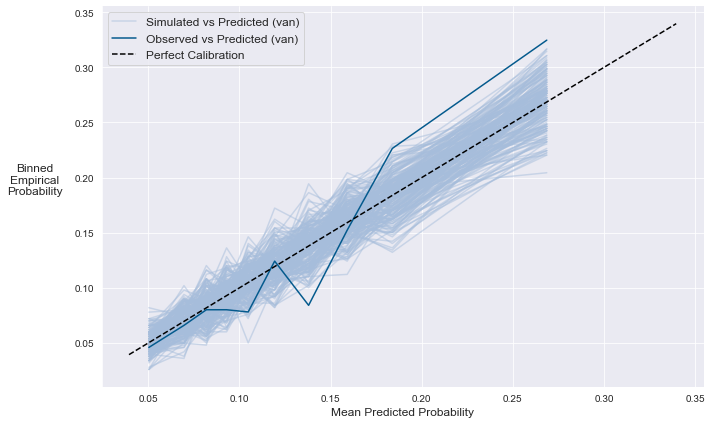

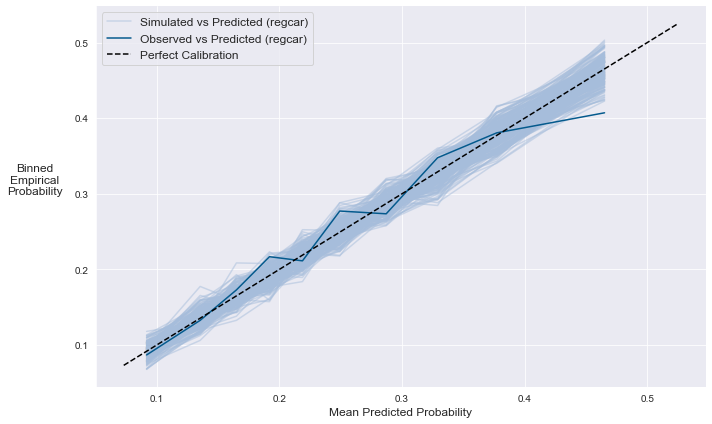

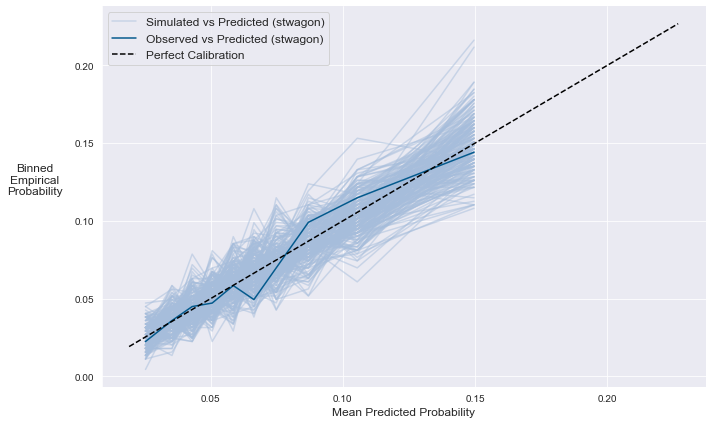

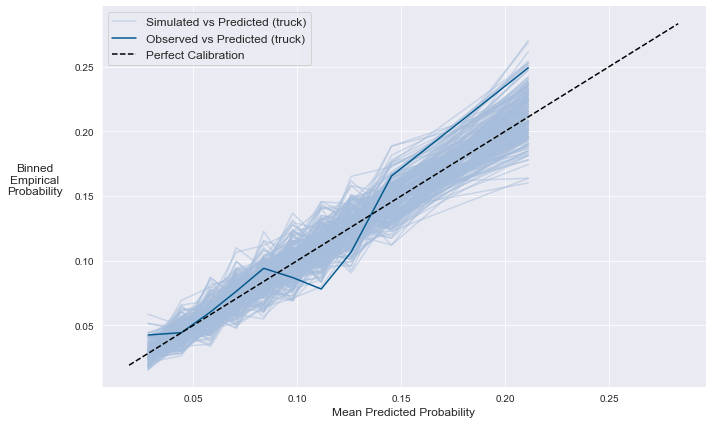

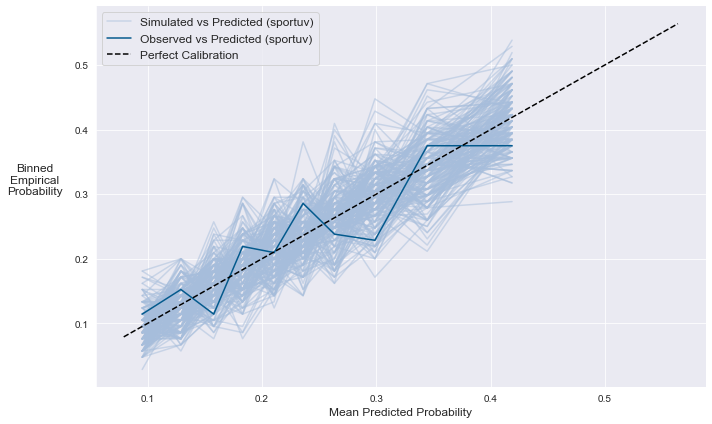

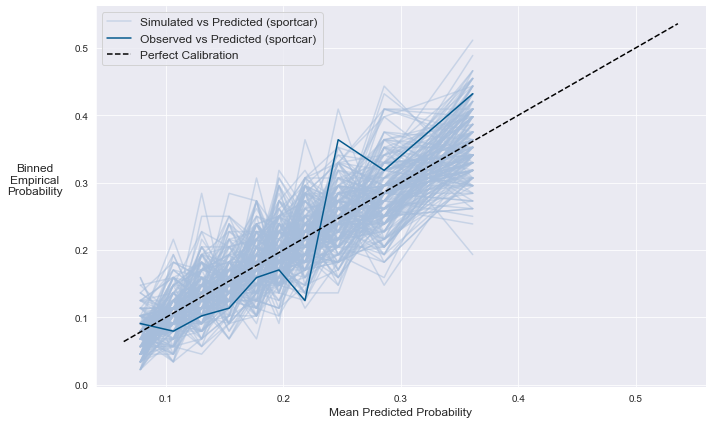

In [23]:
for body in body_types:
    filter_idx = np.where((car_df[BODY_COLUMN] == body).values)
    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = torch_choices.numpy()[filter_idx]
    current_sim_y = sim_choices[filter_idx[0], :]
    current_line_label = 'Observed vs Predicted ({})'.format(body)
    current_sim_label = 'Simulated vs Predicted ({})'.format(body)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    current_plot_fname = 'reliability_plot_body_is_{}.jpg'.format(body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_plot_fname

    reliability_path = None
    viz.plot_smoothed_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=current_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


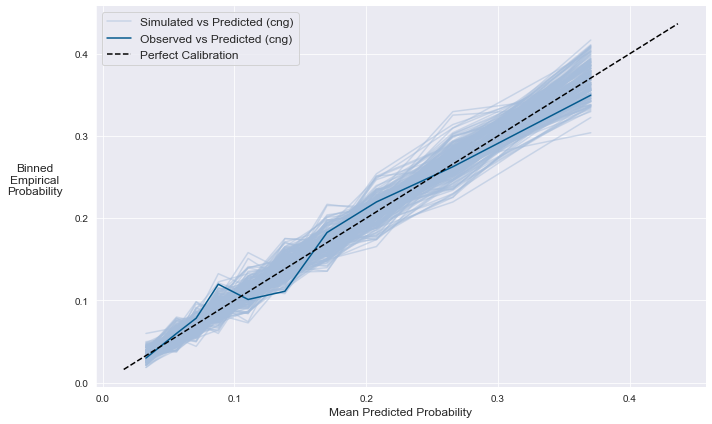

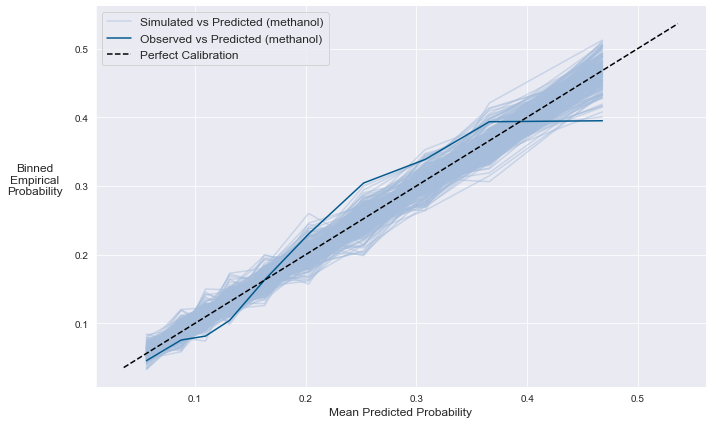

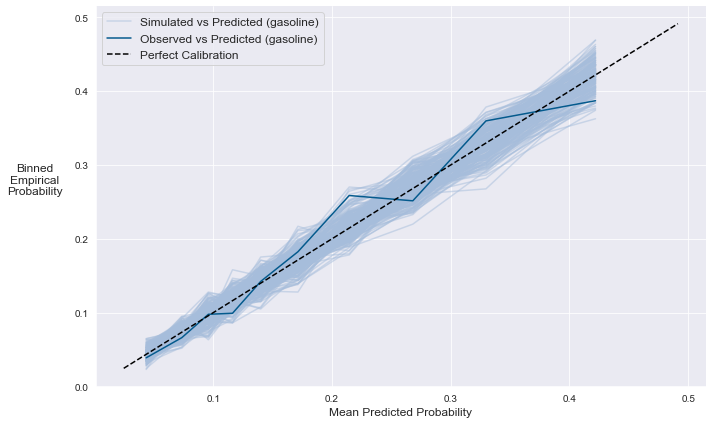

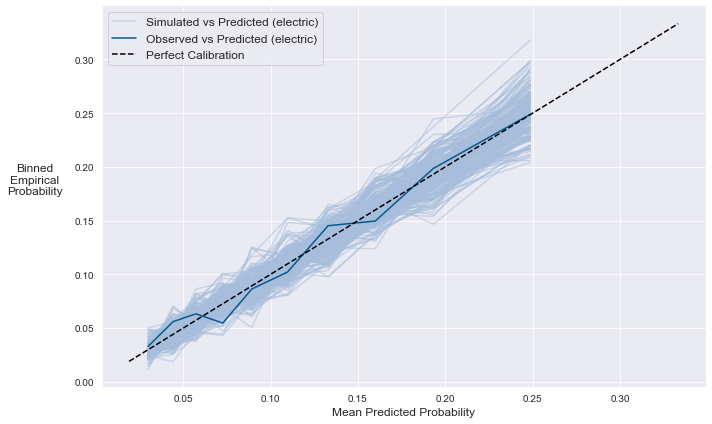

In [24]:
for fuel in fuel_types:
    filter_idx = np.where((car_df[FUEL_COLUMN] == fuel).values)
    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = torch_choices.numpy()[filter_idx]
    current_sim_y = sim_choices[filter_idx[0], :]
    current_line_label = 'Observed vs Predicted ({})'.format(fuel)
    current_sim_label = 'Simulated vs Predicted ({})'.format(fuel)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    current_plot_fname = 'reliability_plot_fuel_is_{}.jpg'.format(fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_plot_fname

    reliability_path = None
    viz.plot_smoothed_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=current_path)

### 3b. Continuously-smoothed reliability plots

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


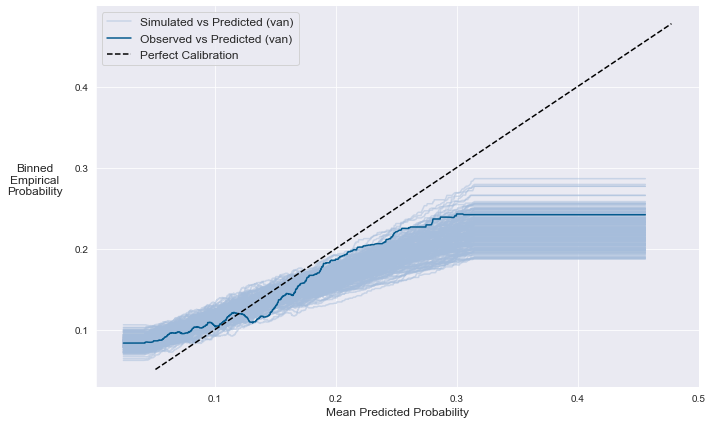

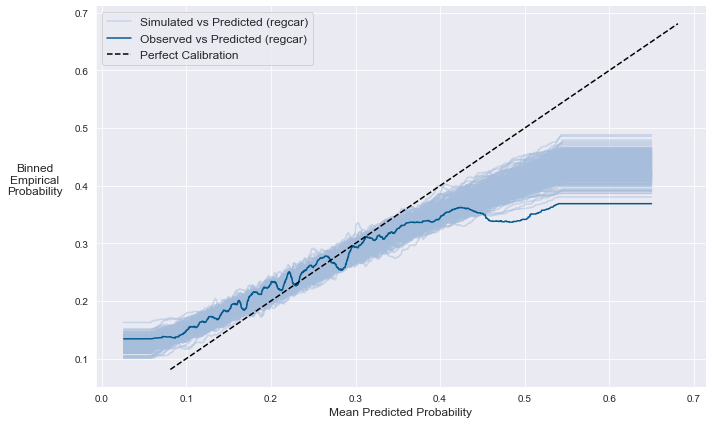

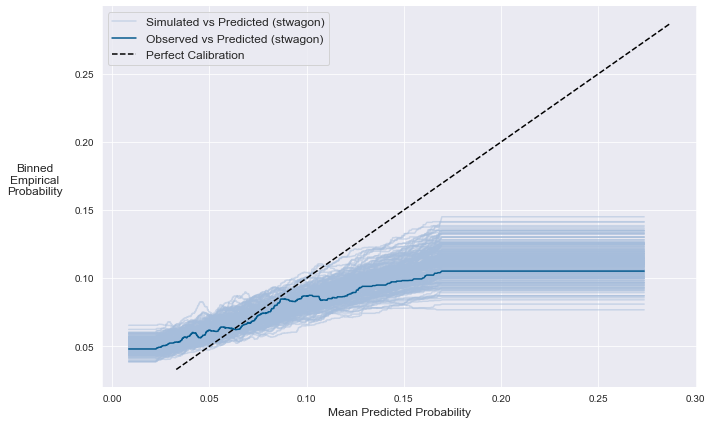

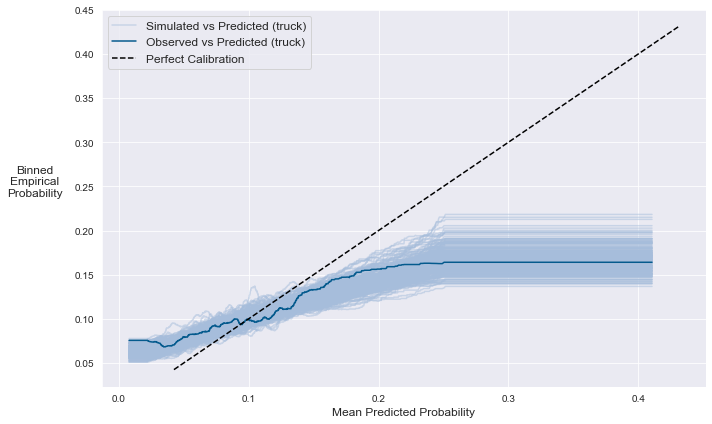

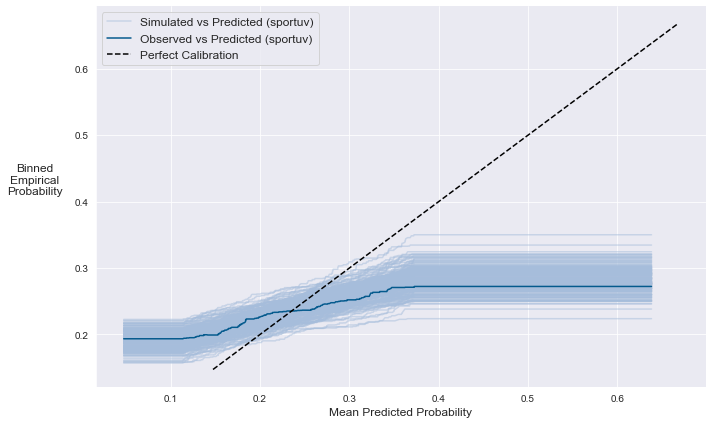

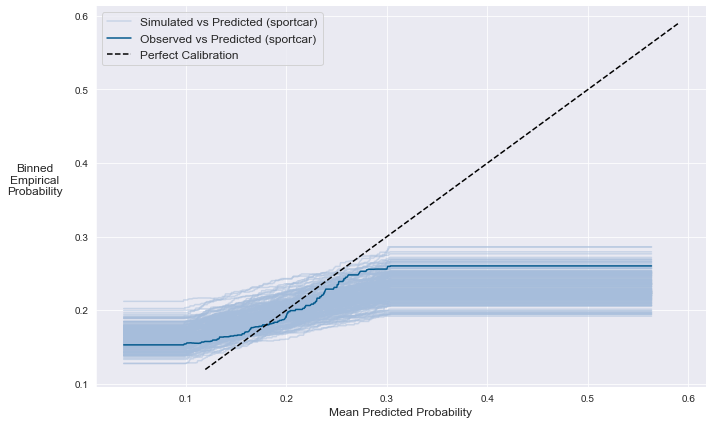

In [39]:
for body in body_types:
    filter_idx = np.where((car_df[BODY_COLUMN] == body).values)
    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = torch_choices.numpy()[filter_idx]
    current_sim_y = sim_choices[filter_idx[0], :]
    current_line_label = 'Observed vs Predicted ({})'.format(body)
    current_sim_label = 'Simulated vs Predicted ({})'.format(body)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    current_plot_fname = 'smoothed_reliability_body_is_{}.jpg'.format(body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_plot_fname

    reliability_path = None
    viz.plot_smoothed_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        discrete=False,
        n_estimators=100,
        min_samples_leaf=100,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=current_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


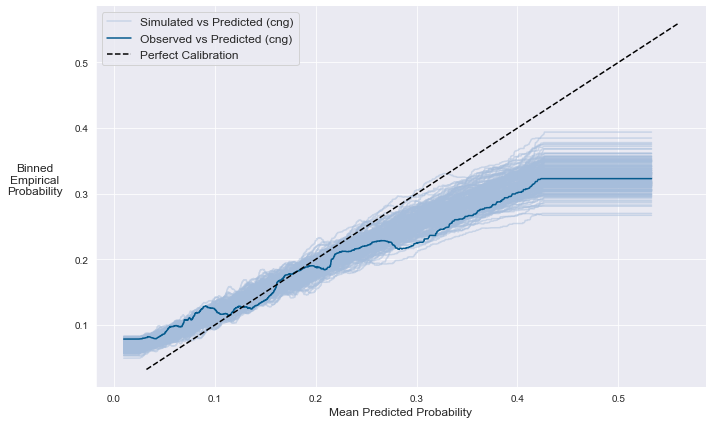

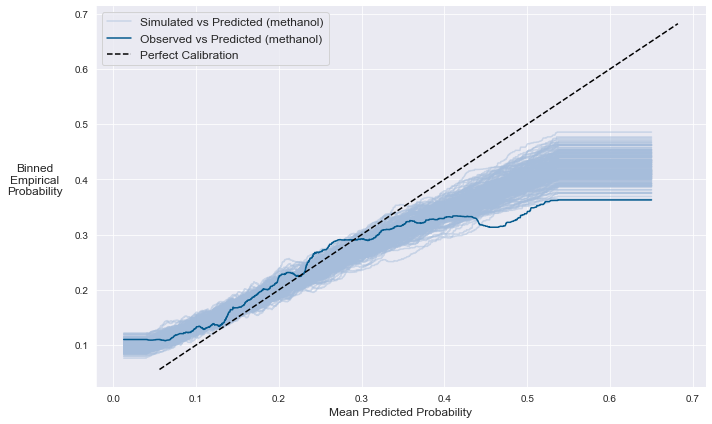

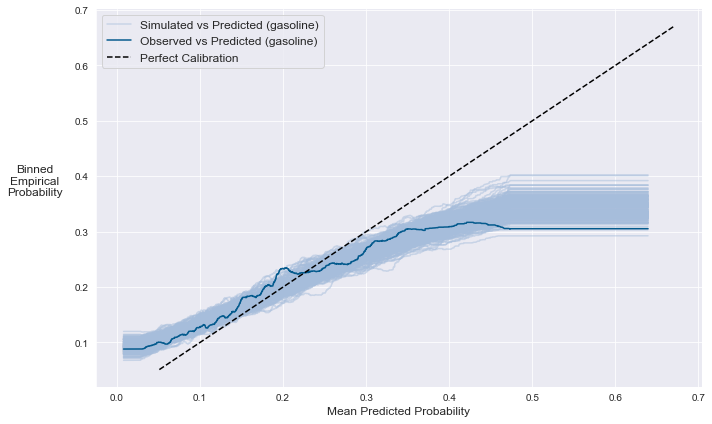

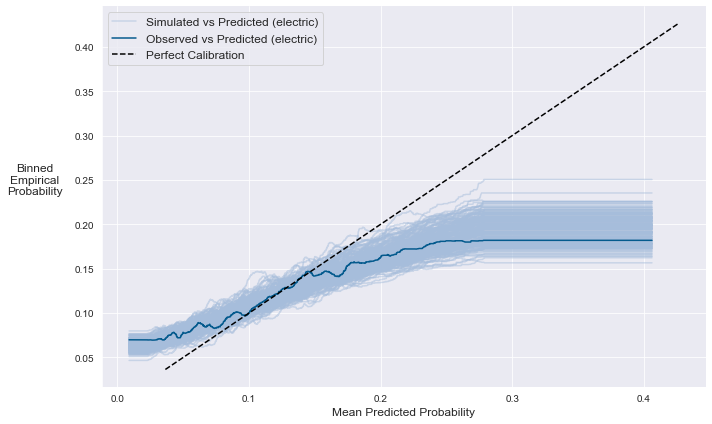

In [38]:
for fuel in fuel_types:
    filter_idx = np.where((car_df[FUEL_COLUMN] == fuel).values)
    current_probs = estimated_probs.numpy()[filter_idx]
    current_choices = torch_choices.numpy()[filter_idx]
    current_sim_y = sim_choices[filter_idx[0], :]
    current_line_label = 'Observed vs Predicted ({})'.format(fuel)
    current_sim_label = 'Simulated vs Predicted ({})'.format(fuel)

    current_sim_color = '#a6bddb'
    current_obs_color = '#045a8d'

    current_plot_fname = 'smoothed_reliability_fuel_is_{}.jpg'.format(fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_plot_fname

    reliability_path = None
    viz.plot_smoothed_reliability(
        current_probs,
        current_choices,
        sim_y=current_sim_y,
        discrete=False,
        n_estimators=100,
        min_samples_leaf=100,
        line_label=current_line_label,
        line_color=current_obs_color,
        sim_label=current_sim_label,
        sim_line_color=current_sim_color,
        figsize=(10, 6),
        ref_line=True,
        output_file=current_path)

## 4. Marginal Model Plots

### 4a. Discretely-smoothed marginal model plots

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


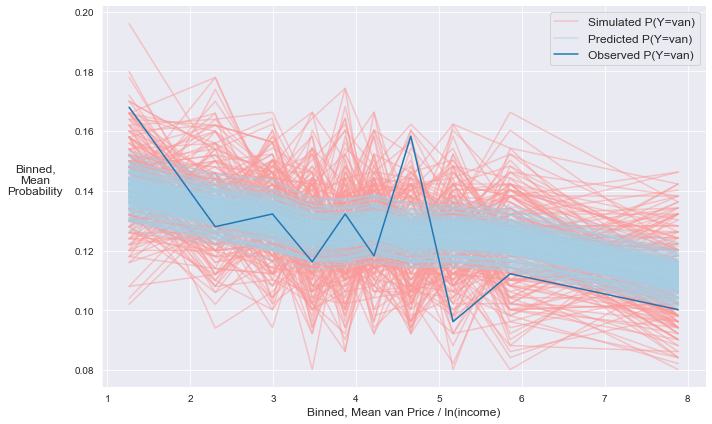

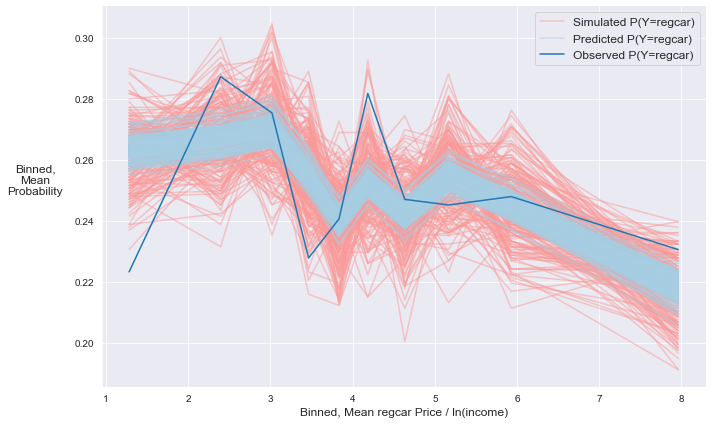

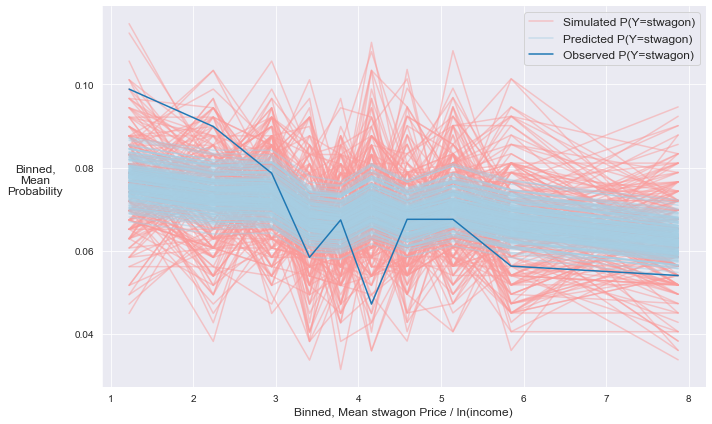

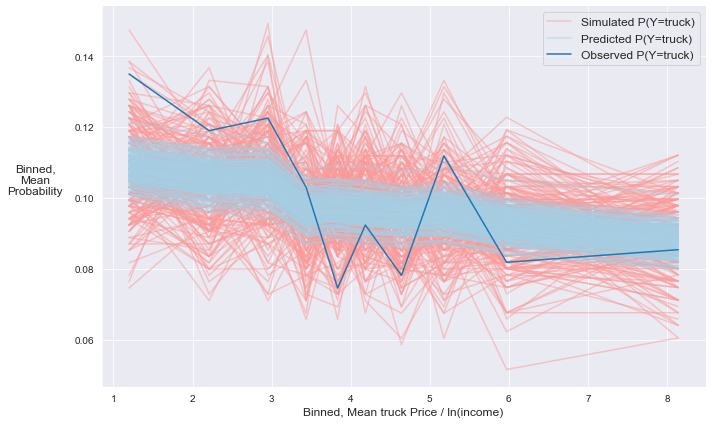

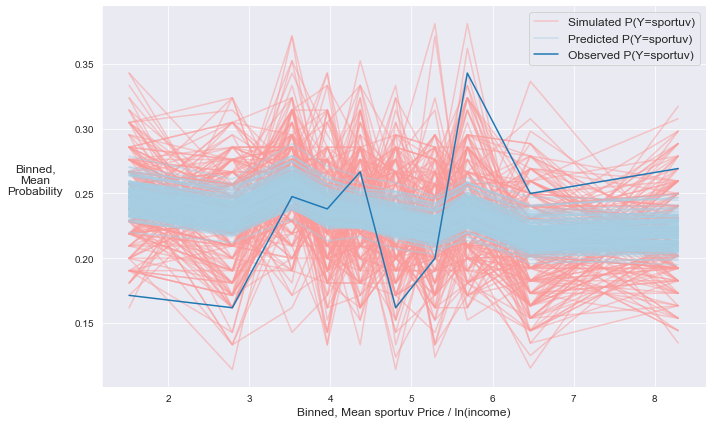

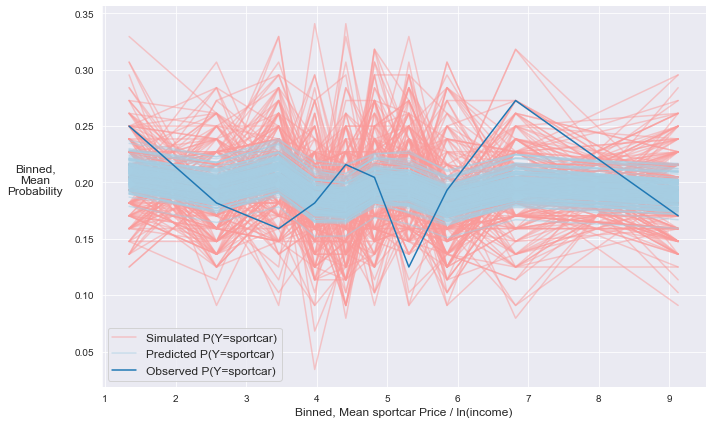

In [25]:
col_of_interest = 'price_over_log_income'
for body in body_types:
    selection_array = (car_df[BODY_COLUMN] == body).values
    selection_idx = np.where(selection_array)

    current_probs = posterior_probs_array[selection_idx[0], :]
    current_y = torch_choices.numpy()[selection_idx]
    current_x = car_df.loc[selection_idx[0], col_of_interest].values
    current_sim_y = sim_choices[selection_idx[0], :]

    current_y_label = 'Observed P(Y={})'.format(body)
    current_prob_label = 'Predicted P(Y={})'.format(body)
    current_sim_label = 'Simulated P(Y={})'.format(body)
    current_x_label =\
        'Binned, Mean {} Price / ln(income)'.format(body)

    current_path_base =\
        'marginal_model_plot_body_eq_{}.jpg'.format(body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_smoothed_marginal(current_sim_y,
                               current_y,
                               current_x,
                               probs=current_probs,
                               partitions=10,
                               y_label=current_y_label,
                               prob_label=current_prob_label,
                               sim_label=current_sim_label,
                               x_label=current_x_label,
                               alpha=0.5,
                               figsize=(10, 6),
                               output_file=current_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


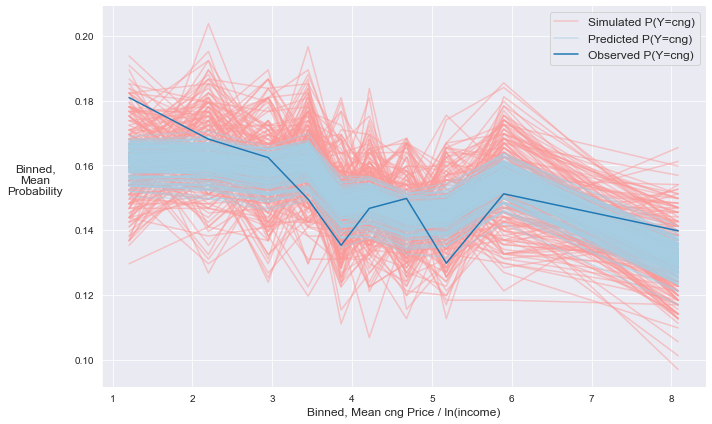

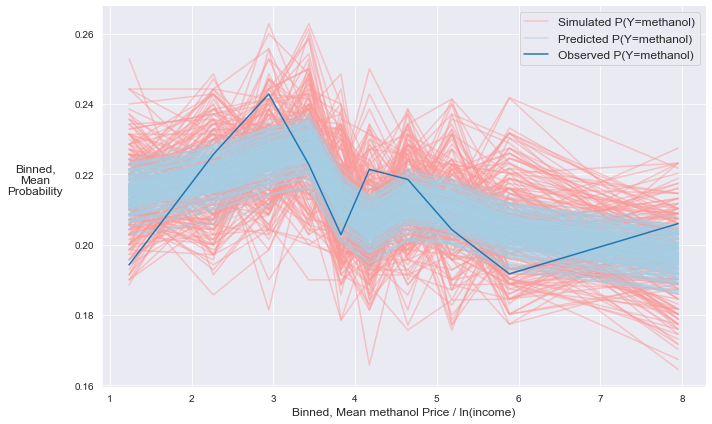

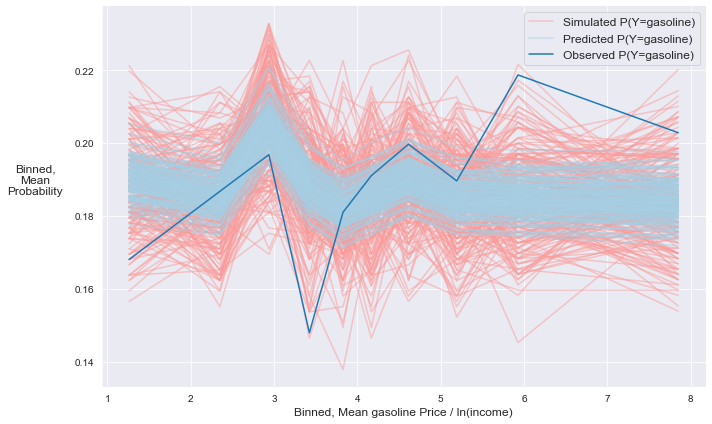

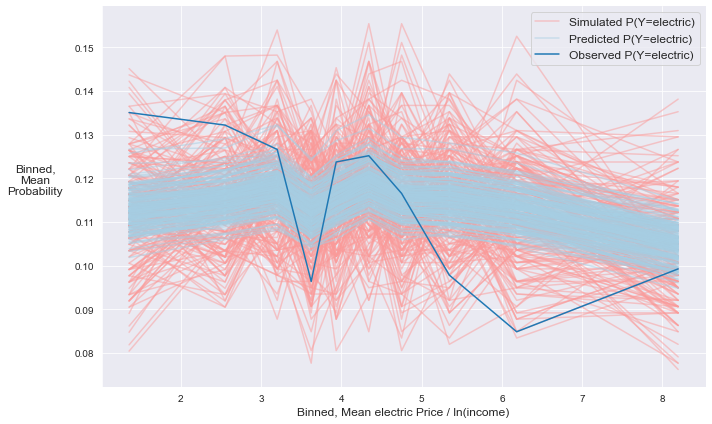

In [26]:
col_of_interest = 'price_over_log_income'
for fuel in fuel_types:
    selection_array = (car_df[FUEL_COLUMN] == fuel).values
    selection_idx = np.where(selection_array)

    current_probs = posterior_probs_array[selection_idx[0], :]
    current_y = torch_choices.numpy()[selection_idx]
    current_x = car_df.loc[selection_idx[0], col_of_interest].values
    current_sim_y = sim_choices[selection_idx[0], :]

    current_y_label = 'Observed P(Y={})'.format(fuel)
    current_prob_label = 'Predicted P(Y={})'.format(fuel)
    current_sim_label = 'Simulated P(Y={})'.format(fuel)
    current_x_label =\
        'Binned, Mean {} Price / ln(income)'.format(fuel)

    current_path_base =\
        'marginal_model_plot_fuel_eq_{}.jpg'.format(fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_smoothed_marginal(current_sim_y,
                               current_y,
                               current_x,
                               probs=current_probs,
                               partitions=10,
                               y_label=current_y_label,
                               prob_label=current_prob_label,
                               sim_label=current_sim_label,
                               x_label=current_x_label,
                               alpha=0.5,
                               figsize=(10, 6),
                               output_file=current_path)

### 4b. Continuously-smoothed marginal model plots

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


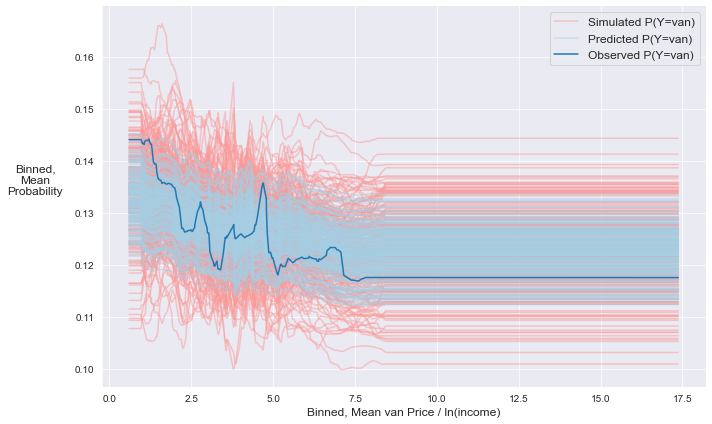

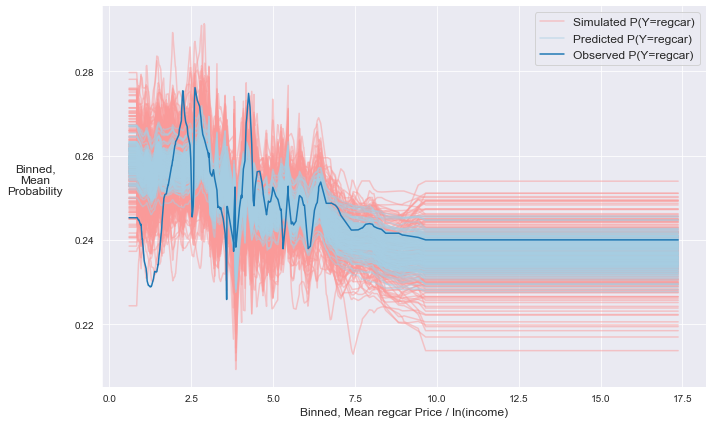

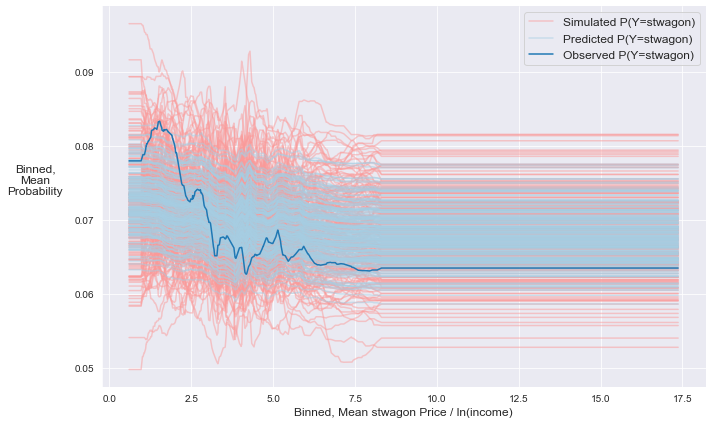

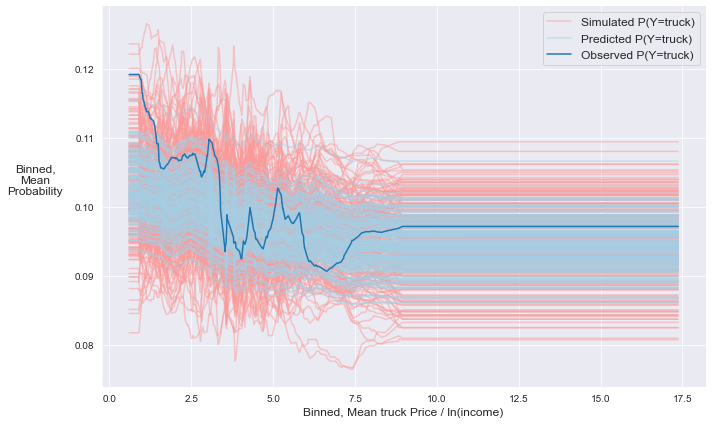

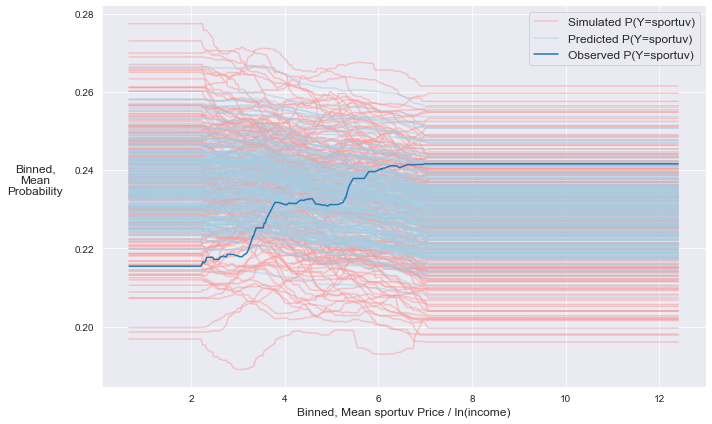

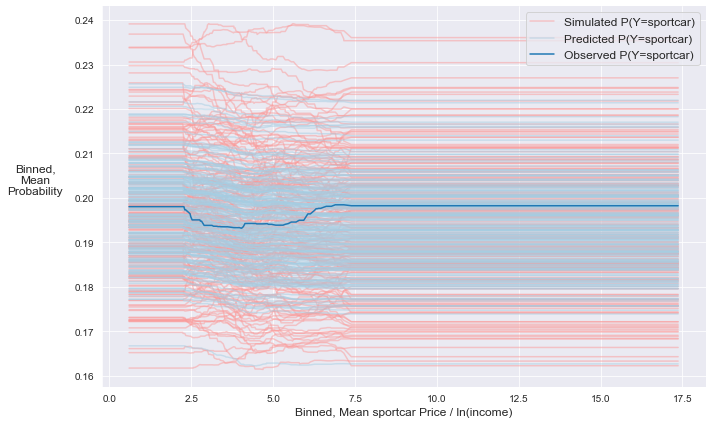

In [40]:
col_of_interest = 'price_over_log_income'
for body in body_types:
    selection_array = (car_df[BODY_COLUMN] == body).values
    selection_idx = np.where(selection_array)

    current_probs = posterior_probs_array[selection_idx[0], :]
    current_y = torch_choices.numpy()[selection_idx]
    current_x = car_df.loc[selection_idx[0], col_of_interest].values
    current_sim_y = sim_choices[selection_idx[0], :]

    current_y_label = 'Observed P(Y={})'.format(body)
    current_prob_label = 'Predicted P(Y={})'.format(body)
    current_sim_label = 'Simulated P(Y={})'.format(body)
    current_x_label =\
        'Binned, Mean {} Price / ln(income)'.format(body)

    current_path_base =\
        'smoothed_marginal_plot_body_eq_{}.jpg'.format(body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_smoothed_marginal(current_sim_y,
                               current_y,
                               current_x,
                               probs=current_probs,
                               discrete=False,
                               n_estimators=100,
                               min_samples_leaf=100,
                               y_label=current_y_label,
                               prob_label=current_prob_label,
                               sim_label=current_sim_label,
                               x_label=current_x_label,
                               alpha=0.5,
                               figsize=(10, 6),
                               output_file=current_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


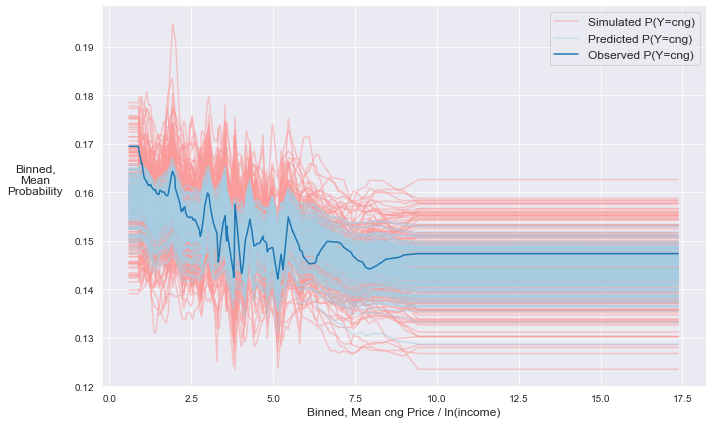

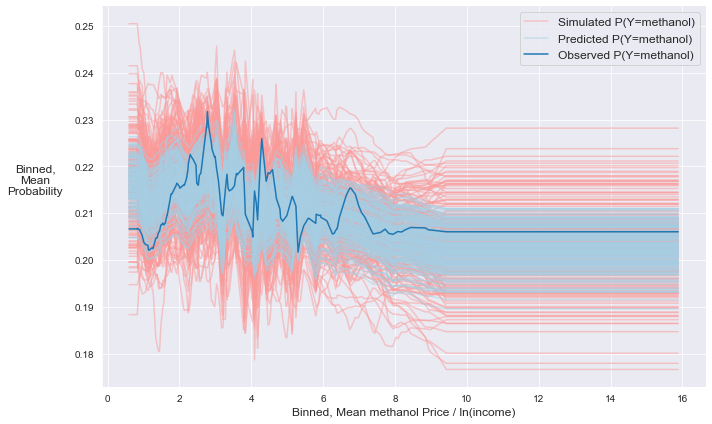

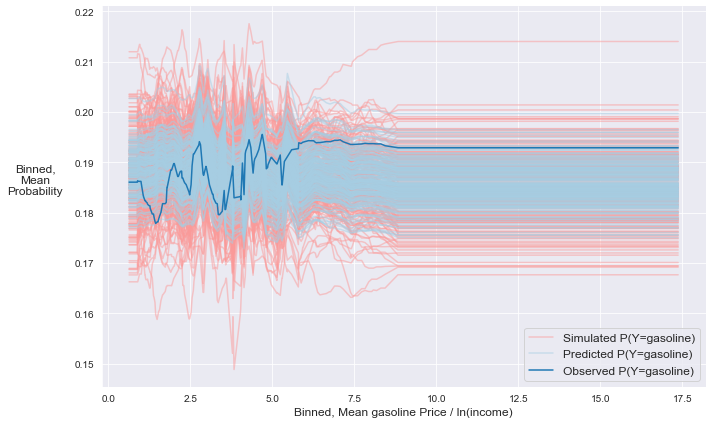

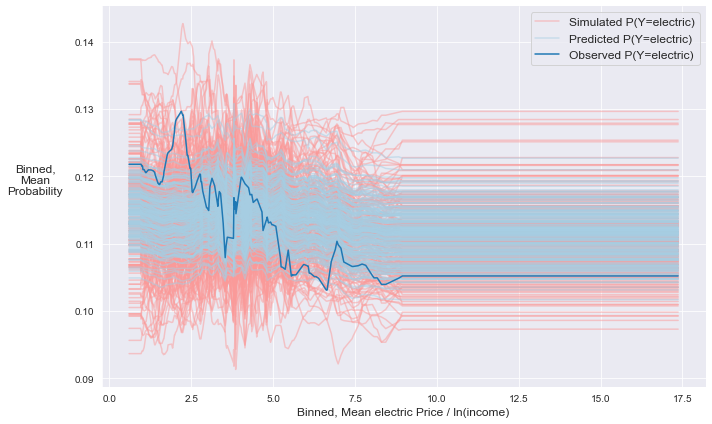

In [41]:
col_of_interest = 'price_over_log_income'
for fuel in fuel_types:
    selection_array = (car_df[FUEL_COLUMN] == fuel).values
    selection_idx = np.where(selection_array)

    current_probs = posterior_probs_array[selection_idx[0], :]
    current_y = torch_choices.numpy()[selection_idx]
    current_x = car_df.loc[selection_idx[0], col_of_interest].values
    current_sim_y = sim_choices[selection_idx[0], :]

    current_y_label = 'Observed P(Y={})'.format(fuel)
    current_prob_label = 'Predicted P(Y={})'.format(fuel)
    current_sim_label = 'Simulated P(Y={})'.format(fuel)
    current_x_label =\
        'Binned, Mean {} Price / ln(income)'.format(fuel)

    current_path_base =\
        'smoothed_marginal_plot_fuel_eq_{}.jpg'.format(fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_smoothed_marginal(current_sim_y,
                               current_y,
                               current_x,
                               probs=current_probs,
                               discrete=False,
                               n_estimators=100,
                               min_samples_leaf=100,
                               y_label=current_y_label,
                               prob_label=current_prob_label,
                               sim_label=current_sim_label,
                               x_label=current_x_label,
                               alpha=0.5,
                               figsize=(10, 6),
                               output_file=current_path)

## 5. Simulated CDFs

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


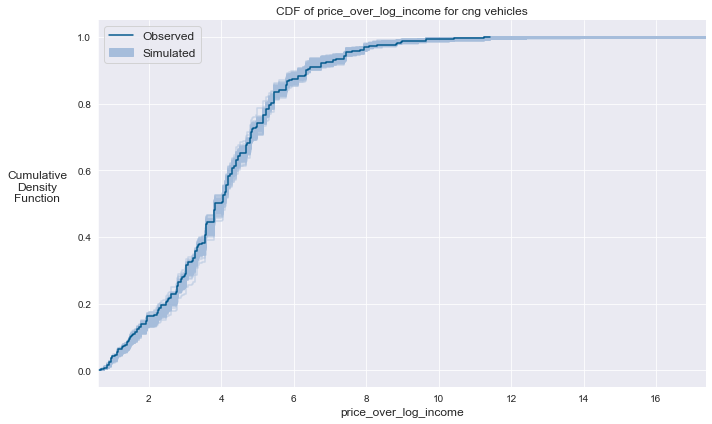

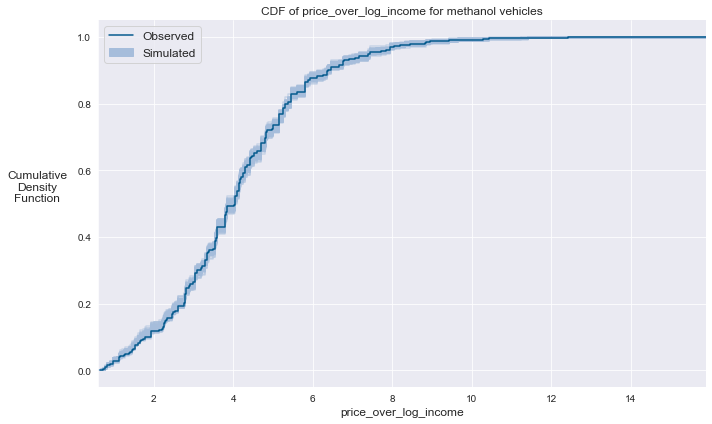

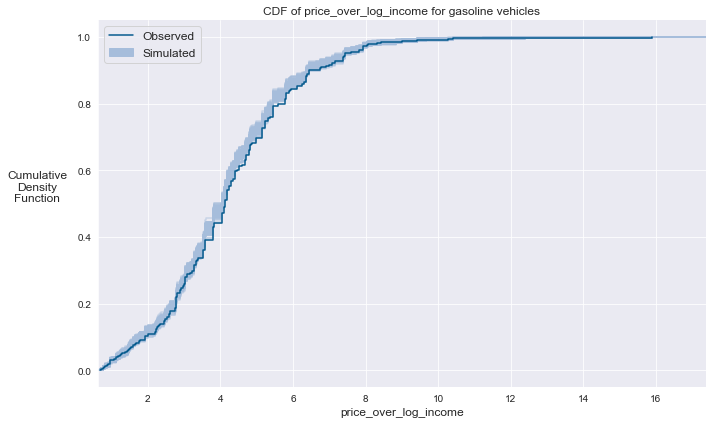

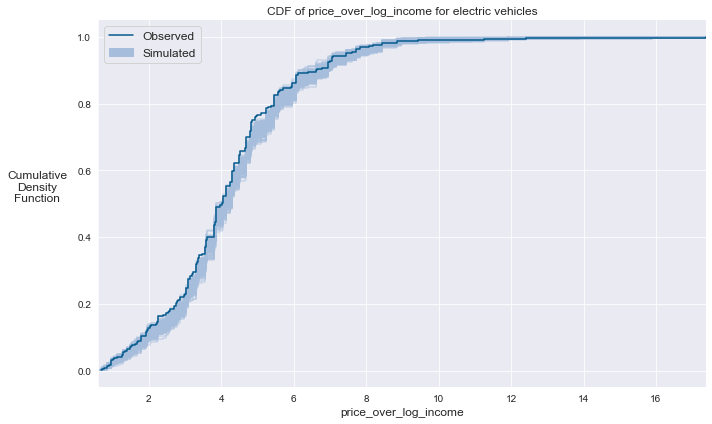

In [27]:
col_of_interest = 'price_over_log_income'
for fuel in fuel_types:
    filter_row = car_df[FUEL_COLUMN] == fuel
    current_title =\
        'CDF of {} for {} vehicles'.format(col_of_interest, fuel)
    current_path_base =\
        'simulated_cdf_{}_fuel_eq_{}.jpg'.format(col_of_interest, fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_simulated_cdfs(sim_choices,
                            car_df,
                            filter_row,
                            col_of_interest,
                            CHOICE_COLUMN,
                            title=current_title,
                            figsize=(10, 6),
                            label='Simulated',
                            output_file=current_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


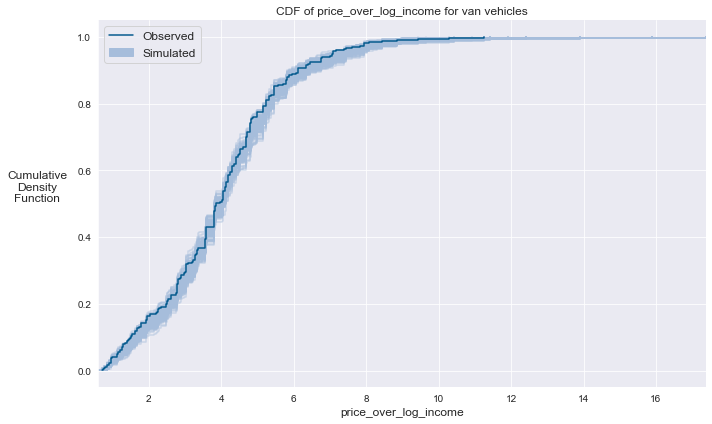

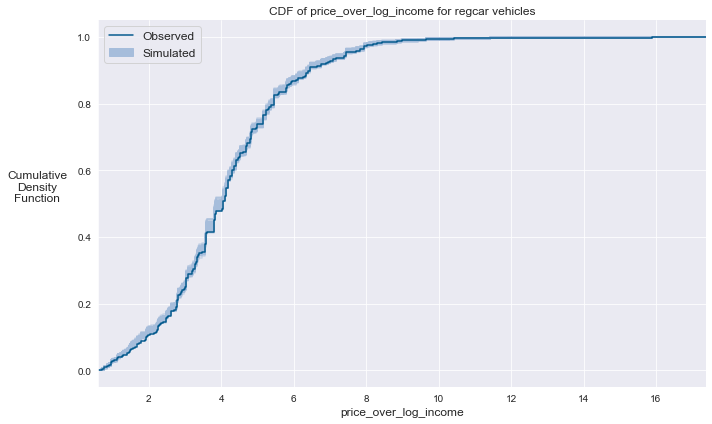

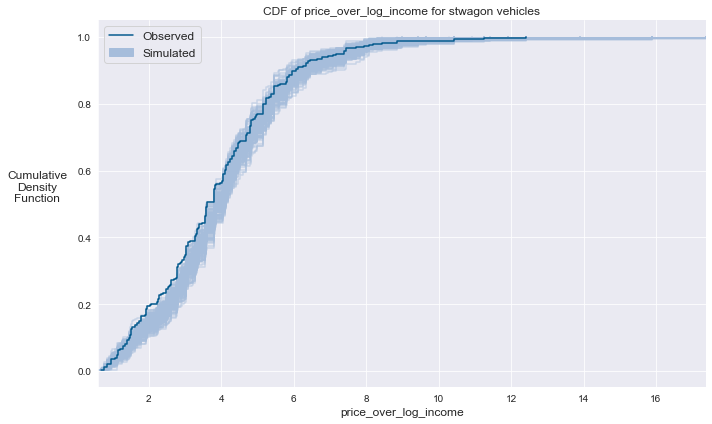

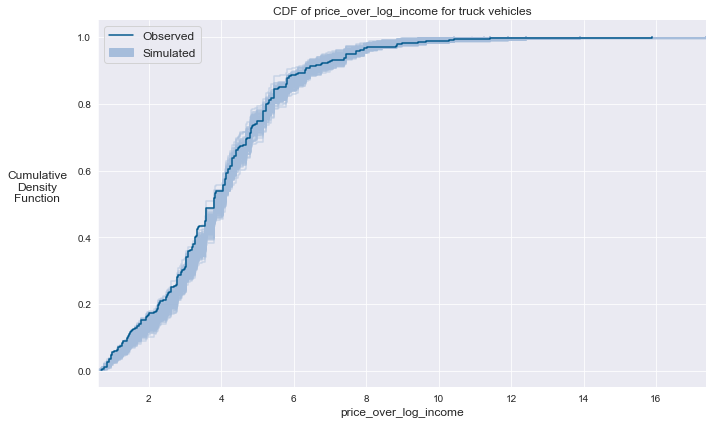

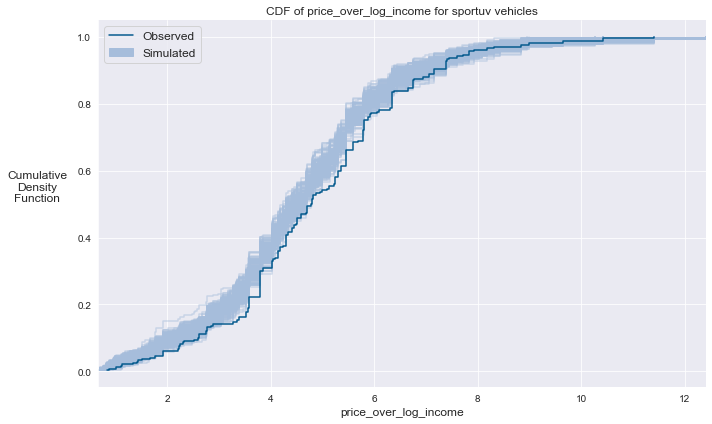

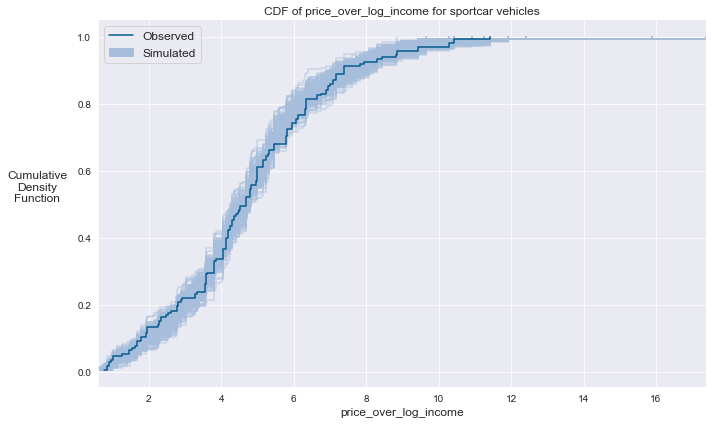

In [28]:
col_of_interest = 'price_over_log_income'
for body in body_types:
    filter_row = car_df[BODY_COLUMN] == body
    current_title =\
        'CDF of {} for {} vehicles'.format(col_of_interest, body)
    current_path_base =\
        'simulated_cdf_{}_body_eq_{}.jpg'.format(col_of_interest, body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_simulated_cdfs(sim_choices,
                            car_df,
                            filter_row,
                            col_of_interest,
                            CHOICE_COLUMN,
                            title=current_title,
                            figsize=(10, 6),
                            label='Simulated',
                            output_file=current_path)

## 6. Simulated KDEs

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


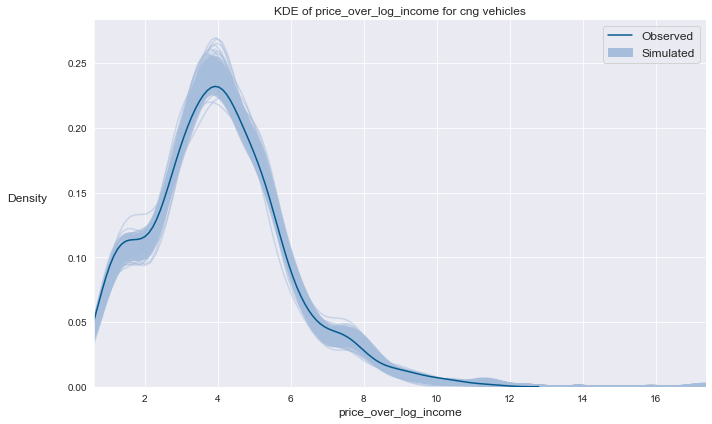

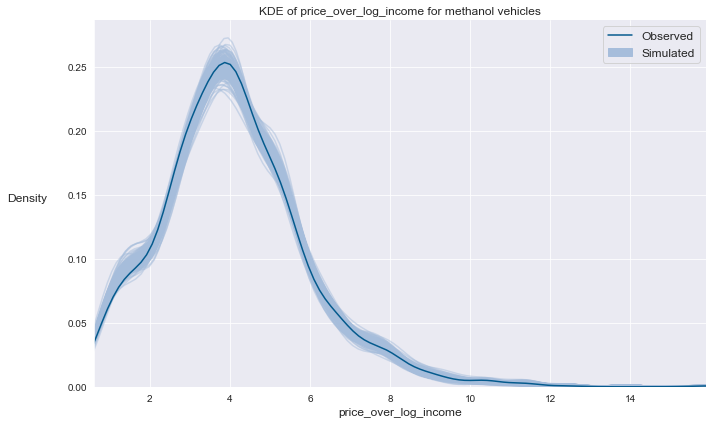

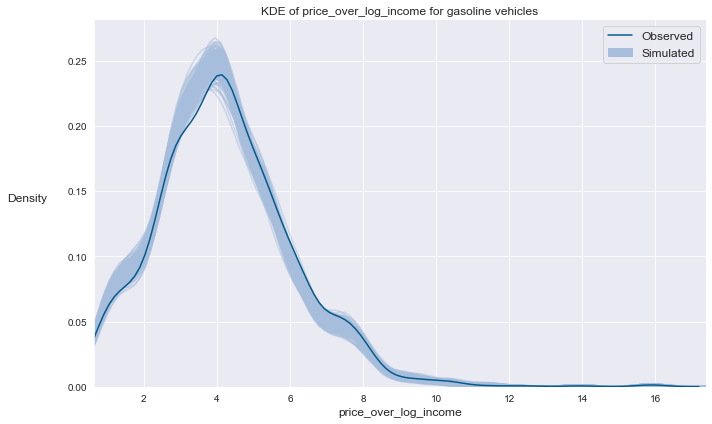

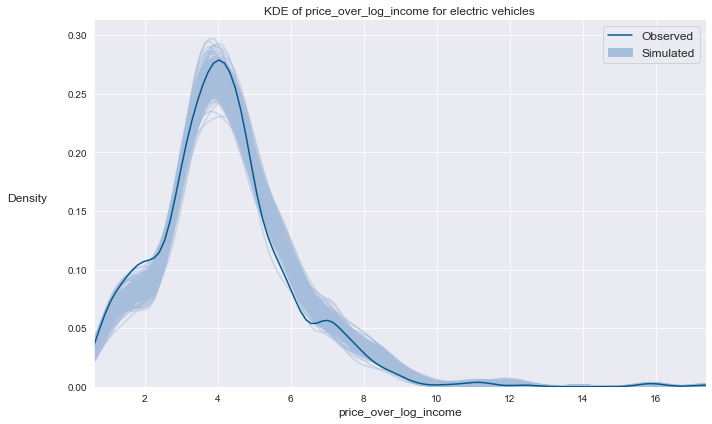

In [29]:
col_of_interest = 'price_over_log_income'
for fuel in fuel_types:
    filter_row = car_df[FUEL_COLUMN] == fuel
    current_title =\
        'KDE of {} for {} vehicles'.format(col_of_interest, fuel)
    current_path_base =\
        'simulated_cdf_{}_fuel_eq_{}.jpg'.format(col_of_interest, fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_simulated_kdes(sim_choices,
                            car_df,
                            filter_row,
                            col_of_interest,
                            CHOICE_COLUMN,
                            title=current_title,
                            figsize=(10, 6),
                            label='Simulated',
                            output_file=current_path)

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


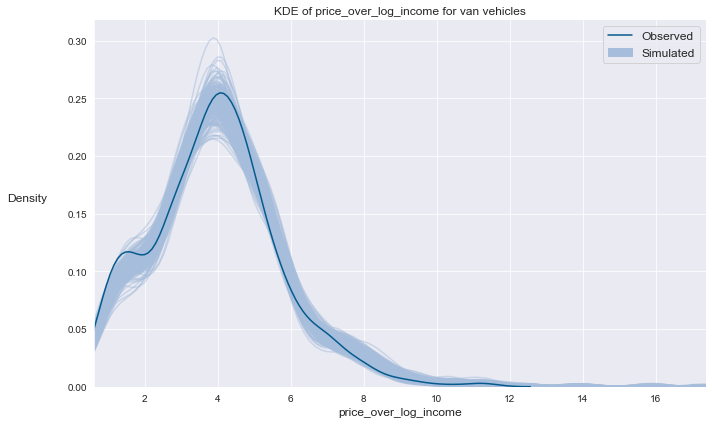

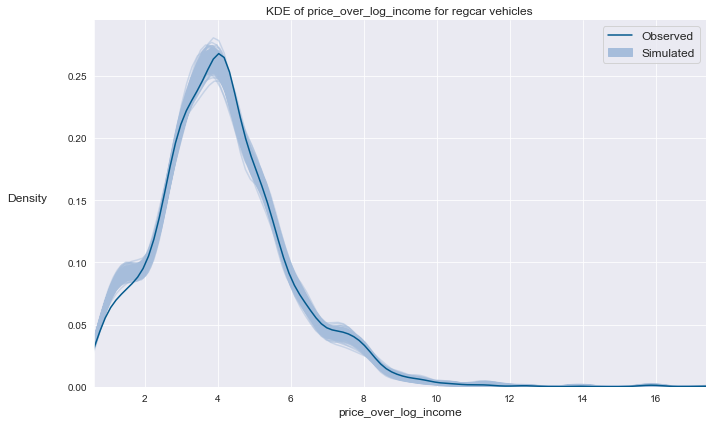

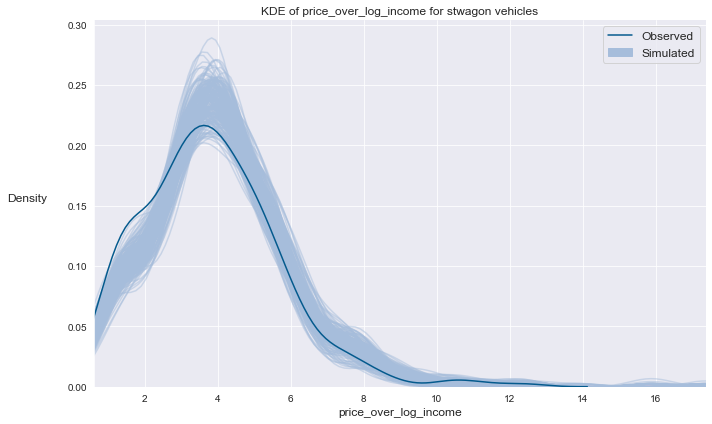

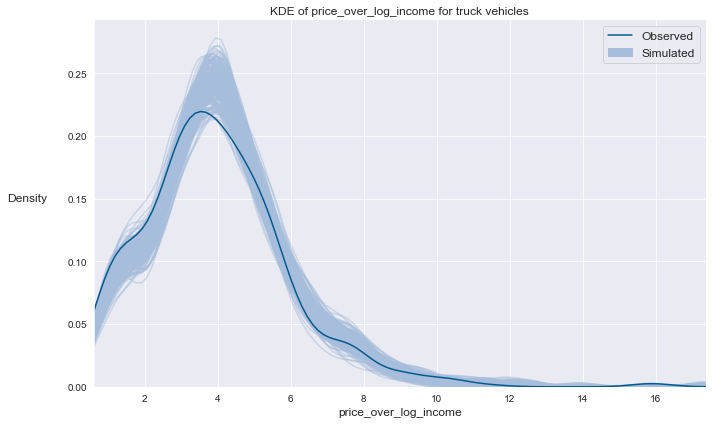

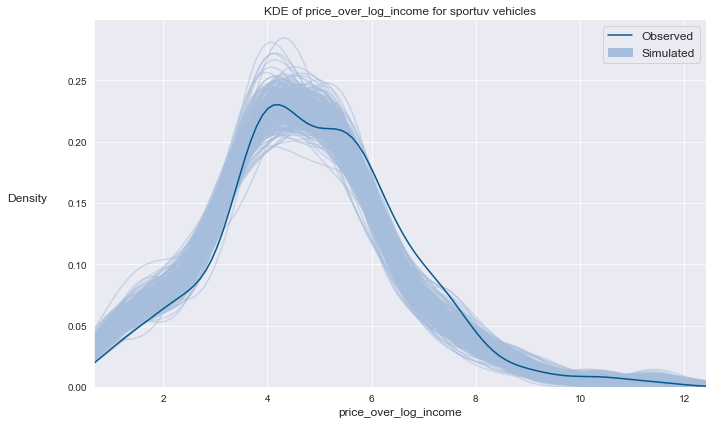

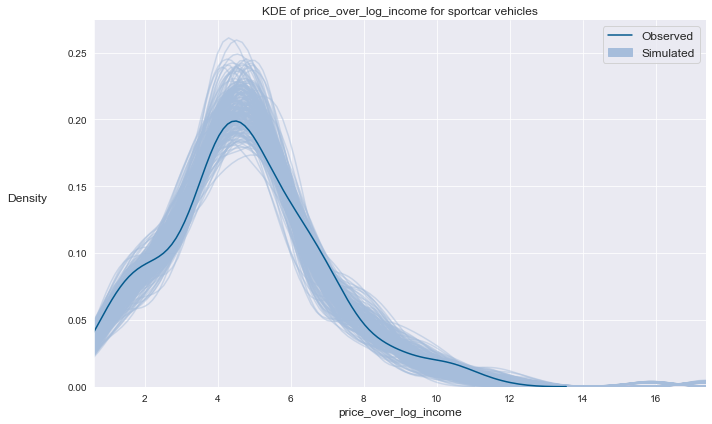

In [30]:
col_of_interest = 'price_over_log_income'
for body in body_types:
    filter_row = car_df[BODY_COLUMN] == body
    current_title =\
        'KDE of {} for {} vehicles'.format(col_of_interest, body)
    current_path_base =\
        'simulated_cdf_{}_body_eq_{}.jpg'.format(col_of_interest, body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_simulated_kdes(sim_choices,
                            car_df,
                            filter_row,
                            col_of_interest,
                            CHOICE_COLUMN,
                            title=current_title,
                            figsize=(10, 6),
                            label='Simulated',
                            output_file=current_path)

## 7. Simulated Histogram

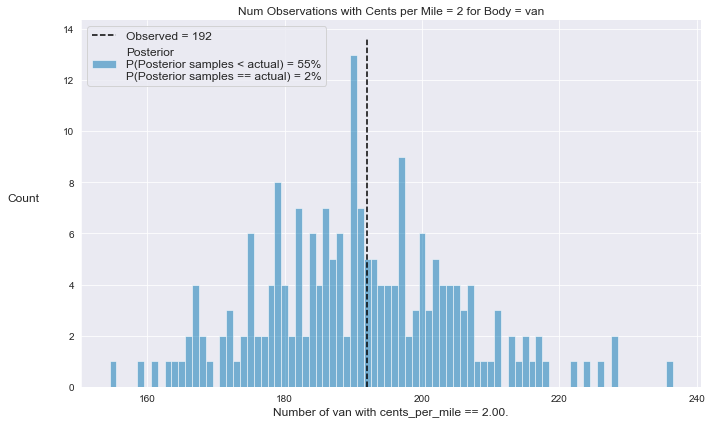

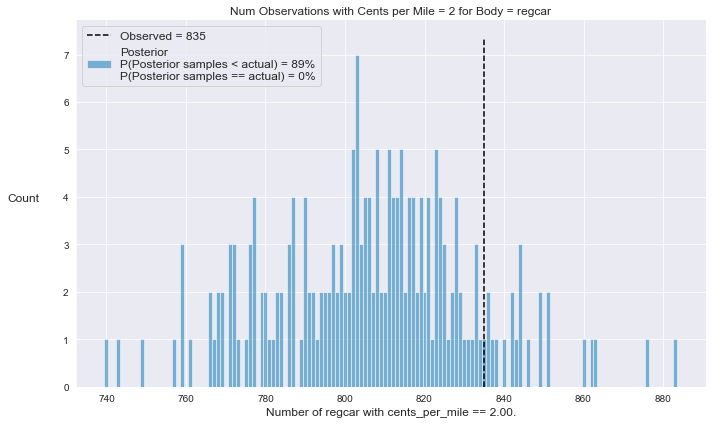

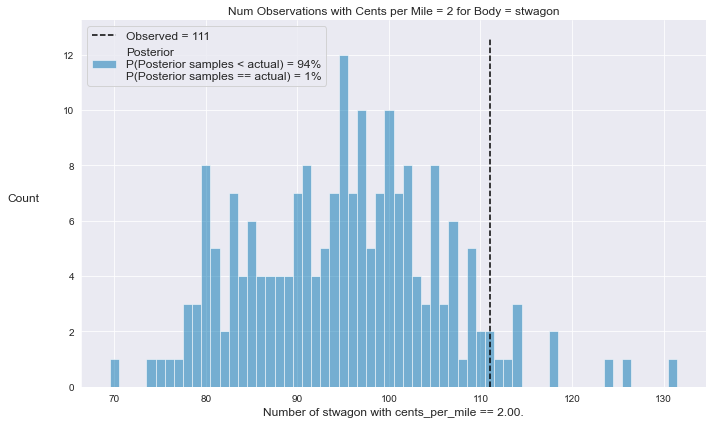

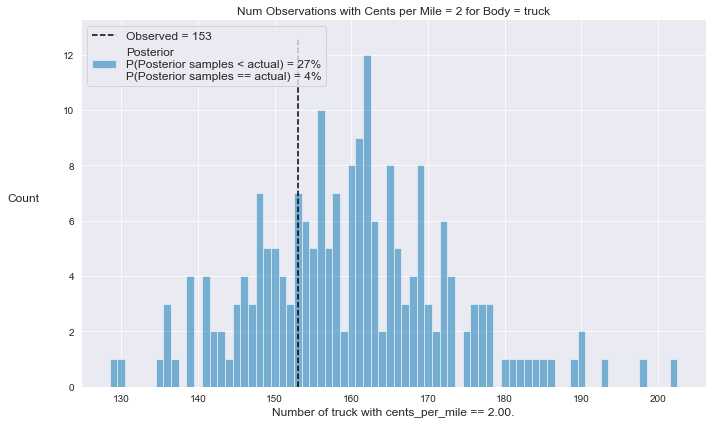

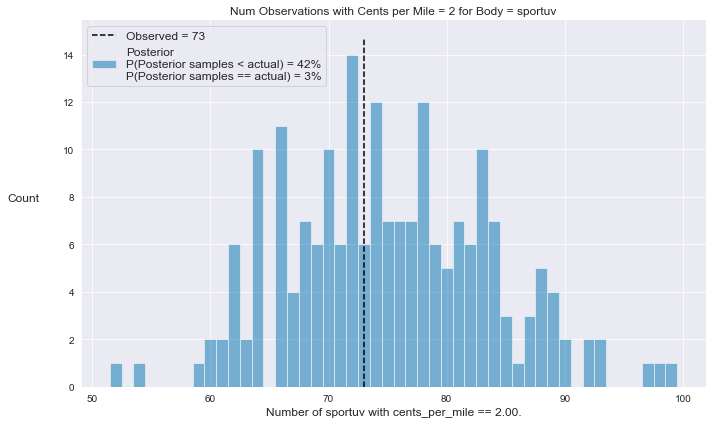

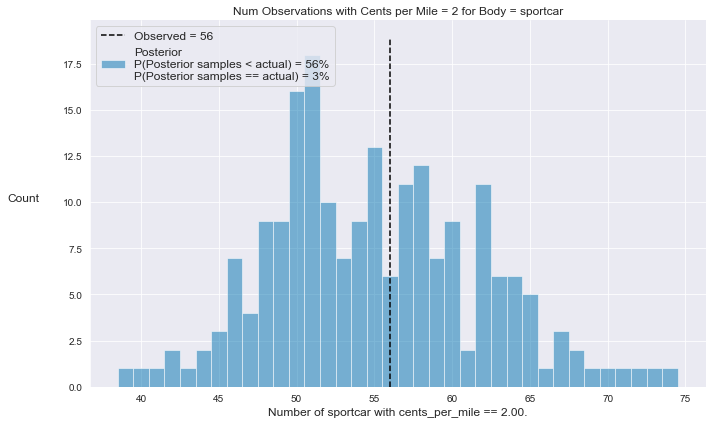

In [36]:
col_of_interest = 'cents_per_mile'
for body in body_types:
    filter_row = ((car_df[BODY_COLUMN] == body) &
                  (car_df[col_of_interest] == 2))
    current_title =\
        'Num Observations with Cents per Mile = 2 for Body = {}'

    current_path_base =\
        'simulated_cdf_{}_eq_2_body_eq_{}.jpg'.format(col_of_interest, body)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_discrete_scalars(
        car_df,
        None,
        sim_choices,
        'cents_per_mile',
        filter_row,
        torch_choices.numpy(),
        title=current_title.format(body),
        filter_name=body,
        post_color=sbn.color_palette('colorblind')[0],
        figsize=(10, 6),
        legend_loc='upper left',
        output_file=str(current_path))

../../src/viz/plot_utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


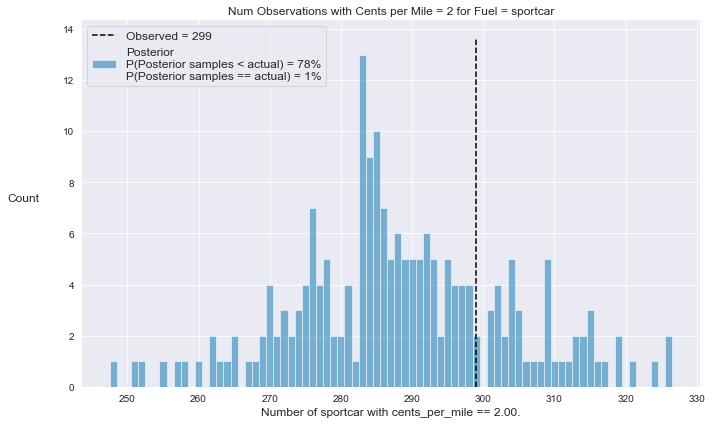

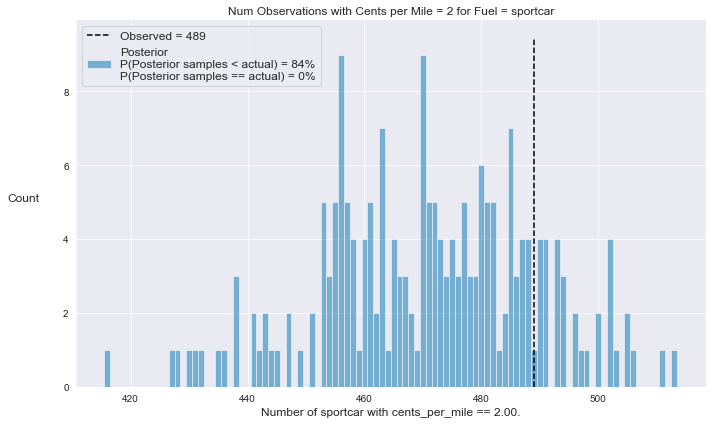

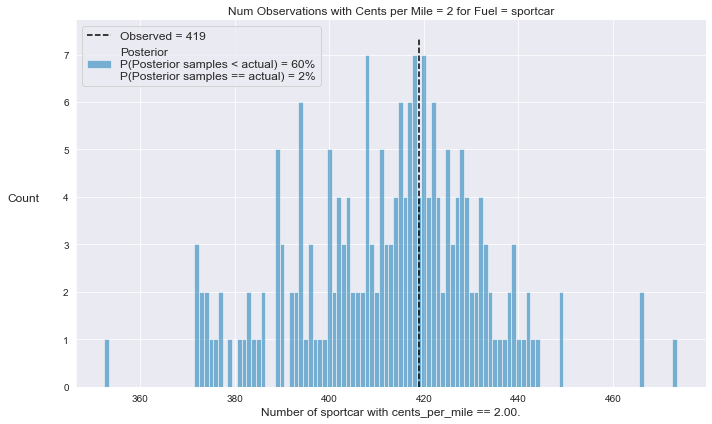

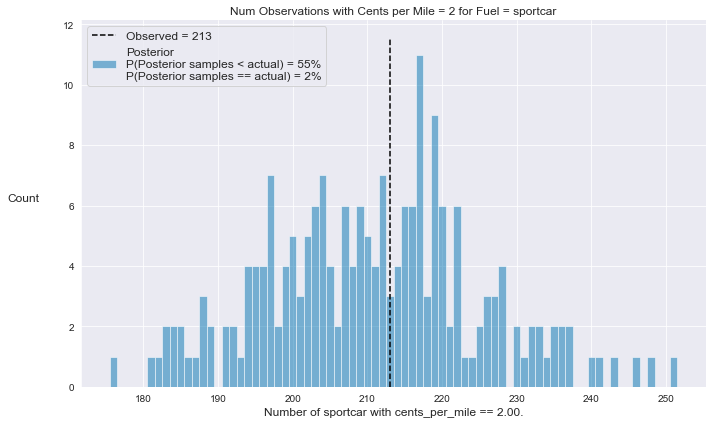

In [37]:
col_of_interest = 'cents_per_mile'
for fuel in fuel_types:
    filter_row = ((car_df[FUEL_COLUMN] == fuel) &
                  (car_df[col_of_interest] == 2))
    current_title =\
        'Num Observations with Cents per Mile = 2 for Fuel = {}'

    current_path_base =\
        'simulated_cdf_{}_eq_2_fuel_eq_{}.jpg'.format(col_of_interest, fuel)
    current_path =\
        pathlib.Path(FIGURE_DIR) / current_path_base

    viz.plot_discrete_scalars(
        car_df,
        None,
        sim_choices,
        'cents_per_mile',
        filter_row,
        torch_choices.numpy(),
        title=current_title.format(body),
        filter_name=body,
        post_color=sbn.color_palette('colorblind')[0],
        figsize=(10, 6),
        legend_loc='upper left',
        output_file=str(current_path))